# Scale Invariant Feature Transform (SIFT)

* Highly cited paper (over 27,000 citations)
* Very well written
* Great explanation of the key ideas of feature detection, as well as key challenges

### Challenges
* Something that is invariant to
    * Translation
    * Rotation
    * Scale
    * Skew (affine transforms)
    * Keystone (projective transforms)
        
* Open problem
    * Harris detection is sensitive to changes in scale
    * Doesn't find the same features at different scales
    
### Scale Space Extrema Detection

* Idea: search across many scales
* Claims "only possible kernel" is the Gaussian
    * Haven't read the citations that underly this statement
    
$L(x,y,\sigma) = G(x,y,\sigma) \ast I(x,y)$

where $\ast$ is the convolution operation and

$G(x,y,\sigma) = \frac{1}{2\pi \sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}}$

Consider the difference-of-Gaussian function

\begin{align}
    D(x,y,\sigma) &= \left(G(x,y,k\sigma) - G(x,y,\sigma)\right) \ast I(x,y) \\
    &= L(x,y,k\sigma) - L(x,y,\sigma)
    \hspace{100em}
\end{align}


Advantages
* Easy to compute
* Efficient to compute
* Need to be computed anyway for scale space feature description
* Simple subtraction after smoothing
* Close approximation to scale-normalized Laplacian of Gaussian 
    * Approximation error approaches 0 as $k$ goes to 1
    * However, is fine even if $k=\sqrt{2}$

### Difference of Gaussians Construction 
* Initial image is convolved with Gaussians
* Separated by constant factor $k$ in scale space
* Typically each octave (doubling of $\sigma$) divided into integer number of intervals
    * Intervals between difference of Gaussians
    * Note that if we want $s$ intervals, we need $s+1$ differences of Gaussians
    * And we'll need $s+2$ Gaussians 
    * In order to find the maxima of the top, we'll need yet another layer on top, which leads to $s+3$
    * This took me quite a while to figure out
* In this case $k=2^{1/s}$
* Once the smoothing goes up by an octave (2 down from the top), can subsample by factor of 2
    * Take every second pixel in rows and columns
    * Note that we need to keep track of the pixel locations
    * The only motivation for subsampling is to reduce computation
* This is another type of image pyramid
  

In [2]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
import PSUCV as pcv
import scipy.signal 

#filename = 'chessboard.jpg'
#img = cv2.imread(filename)

#imagePath = os.path.join(os.path.expanduser('~'),'Temp','Test.jpg')
image = cv.imread('images/Bourbon.jpeg',cv.IMREAD_GRAYSCALE)
#imageBGR = cv.imread(imagePath)
#imageBGR = imageBGR[1700:1750,1500:1600] # CROP
#imageBGR = imageBGR[1700:1900,1500:1900] # CROP
#imageBGR = imageBGR[1500:1900,1500:2300] # CROP
#imageRGB  = cv2.cvtColor(imageBGR,cv2.COLOR_BGR2RGB)
#imageGray = cv2.cvtColor(imageBGR,cv2.COLOR_BGR2GRAY)
imageGray = image[200:900,700:2000] # Crop
imageGray = cv.pyrDown(imageGray)
imageGray = cv.pyrDown(imageGray)
#imageGray = cv.pyrDown(imageGray)
imageGray = np.array(imageGray).astype(np.float32)
imageGray -= imageGray.min()
imageGray /= imageGray.max()


Sum of Gaussian Kernel: 1.0


Text(0, 0.5, 'Difference')

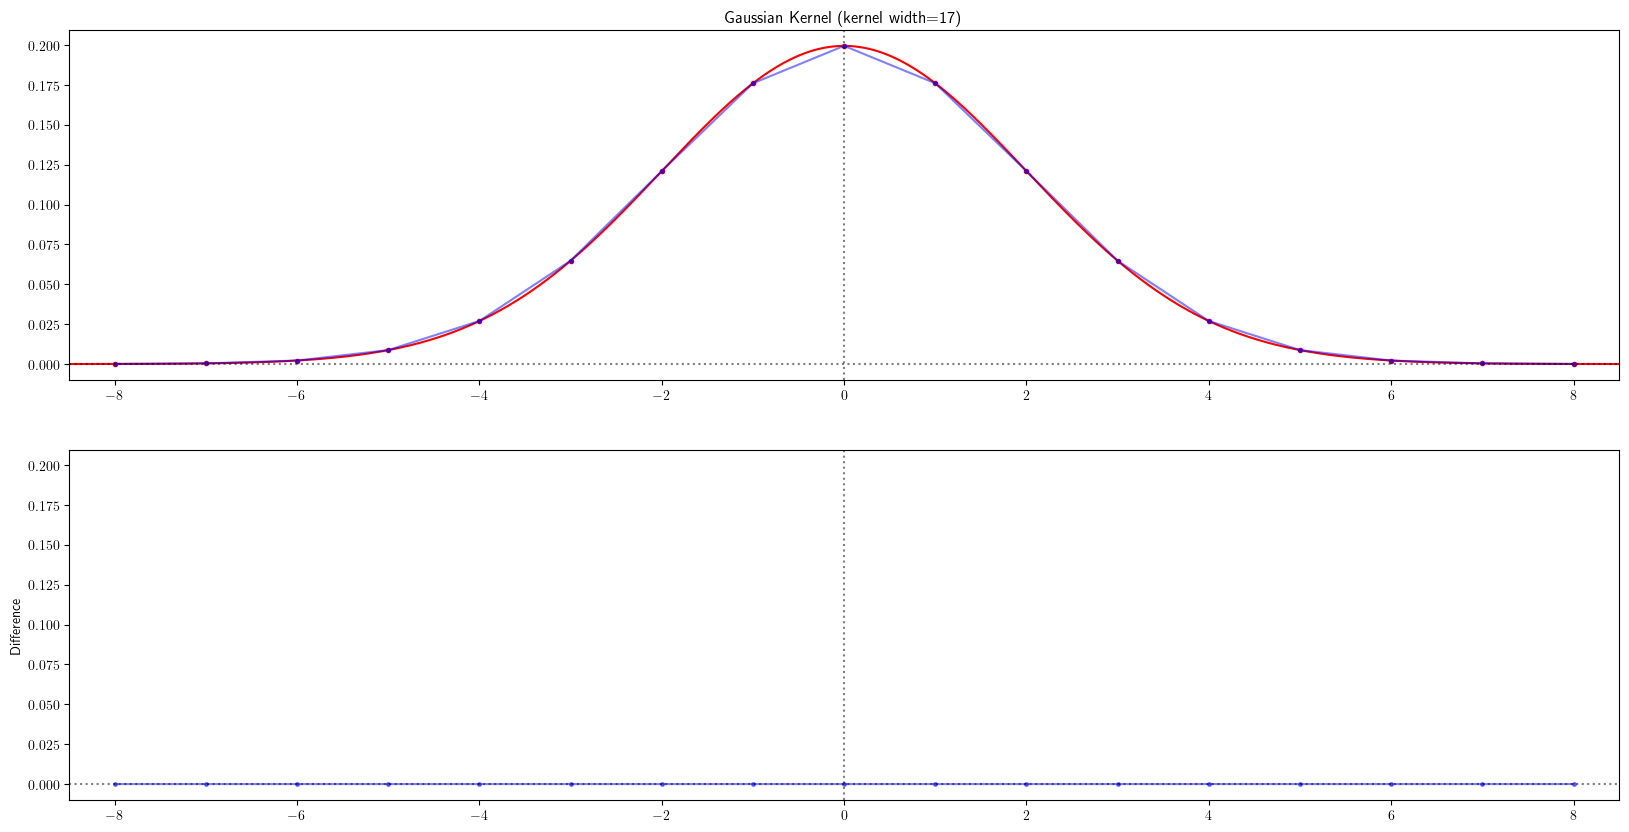

In [3]:
#%% Gaussian Kernel Width
def Normal(t,sigma):
    p = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (t)**2 / (2 * sigma**2))
    return p

sigma = 2.0 # Standard deviation in units of pixels
kernelWidth = max(3,int(sigma*4*2)+int(sigma*4*2)%2+1)

gk = cv.getGaussianKernel(kernelWidth,sigma)
gk = gk.transpose()[0]
k  = np.arange(-(kernelWidth-1)/2,(kernelWidth-1)/2+1)

print('Sum of Gaussian Kernel: %3.1f' % np.sum(gk))

t = np.linspace(-kernelWidth/2,kernelWidth/2,1000)
s = Normal(t,sigma)
sk = Normal(k,sigma)

figure = plt.figure()
figure.clf()
figure.set_size_inches(20,10)

figure.clf()
axes = figure.add_subplot(211)
axes.plot(t,s,color='r')
axes.plot(k,sk,marker='.',color='r',linestyle='None')
axes.plot(k,gk,marker='.',color='b',alpha=0.5,markersize=5)
axes.axhline(0,color='k',linestyle=':',alpha=0.5)
axes.axvline(0,color='k',linestyle=':',alpha=0.5)
axes.set_xlim([t[0],t[-1]])
axes.set_ylim([-0.05*s.max(),1.05*s.max()])
axes.set_title('Gaussian Kernel (kernel width=%d)' % kernelWidth)

axes = figure.add_subplot(212)
axes.plot(k,gk-sk,marker='.',color='b',alpha=0.5,markersize=5)
axes.axhline(0,color='k',linestyle=':',alpha=0.5)
axes.axvline(0,color='k',linestyle=':',alpha=0.5)
axes.set_xlim([t[0],t[-1]])
axes.set_ylim([-0.05*s.max(),1.05*s.max()])
axes.set_ylabel('Difference')

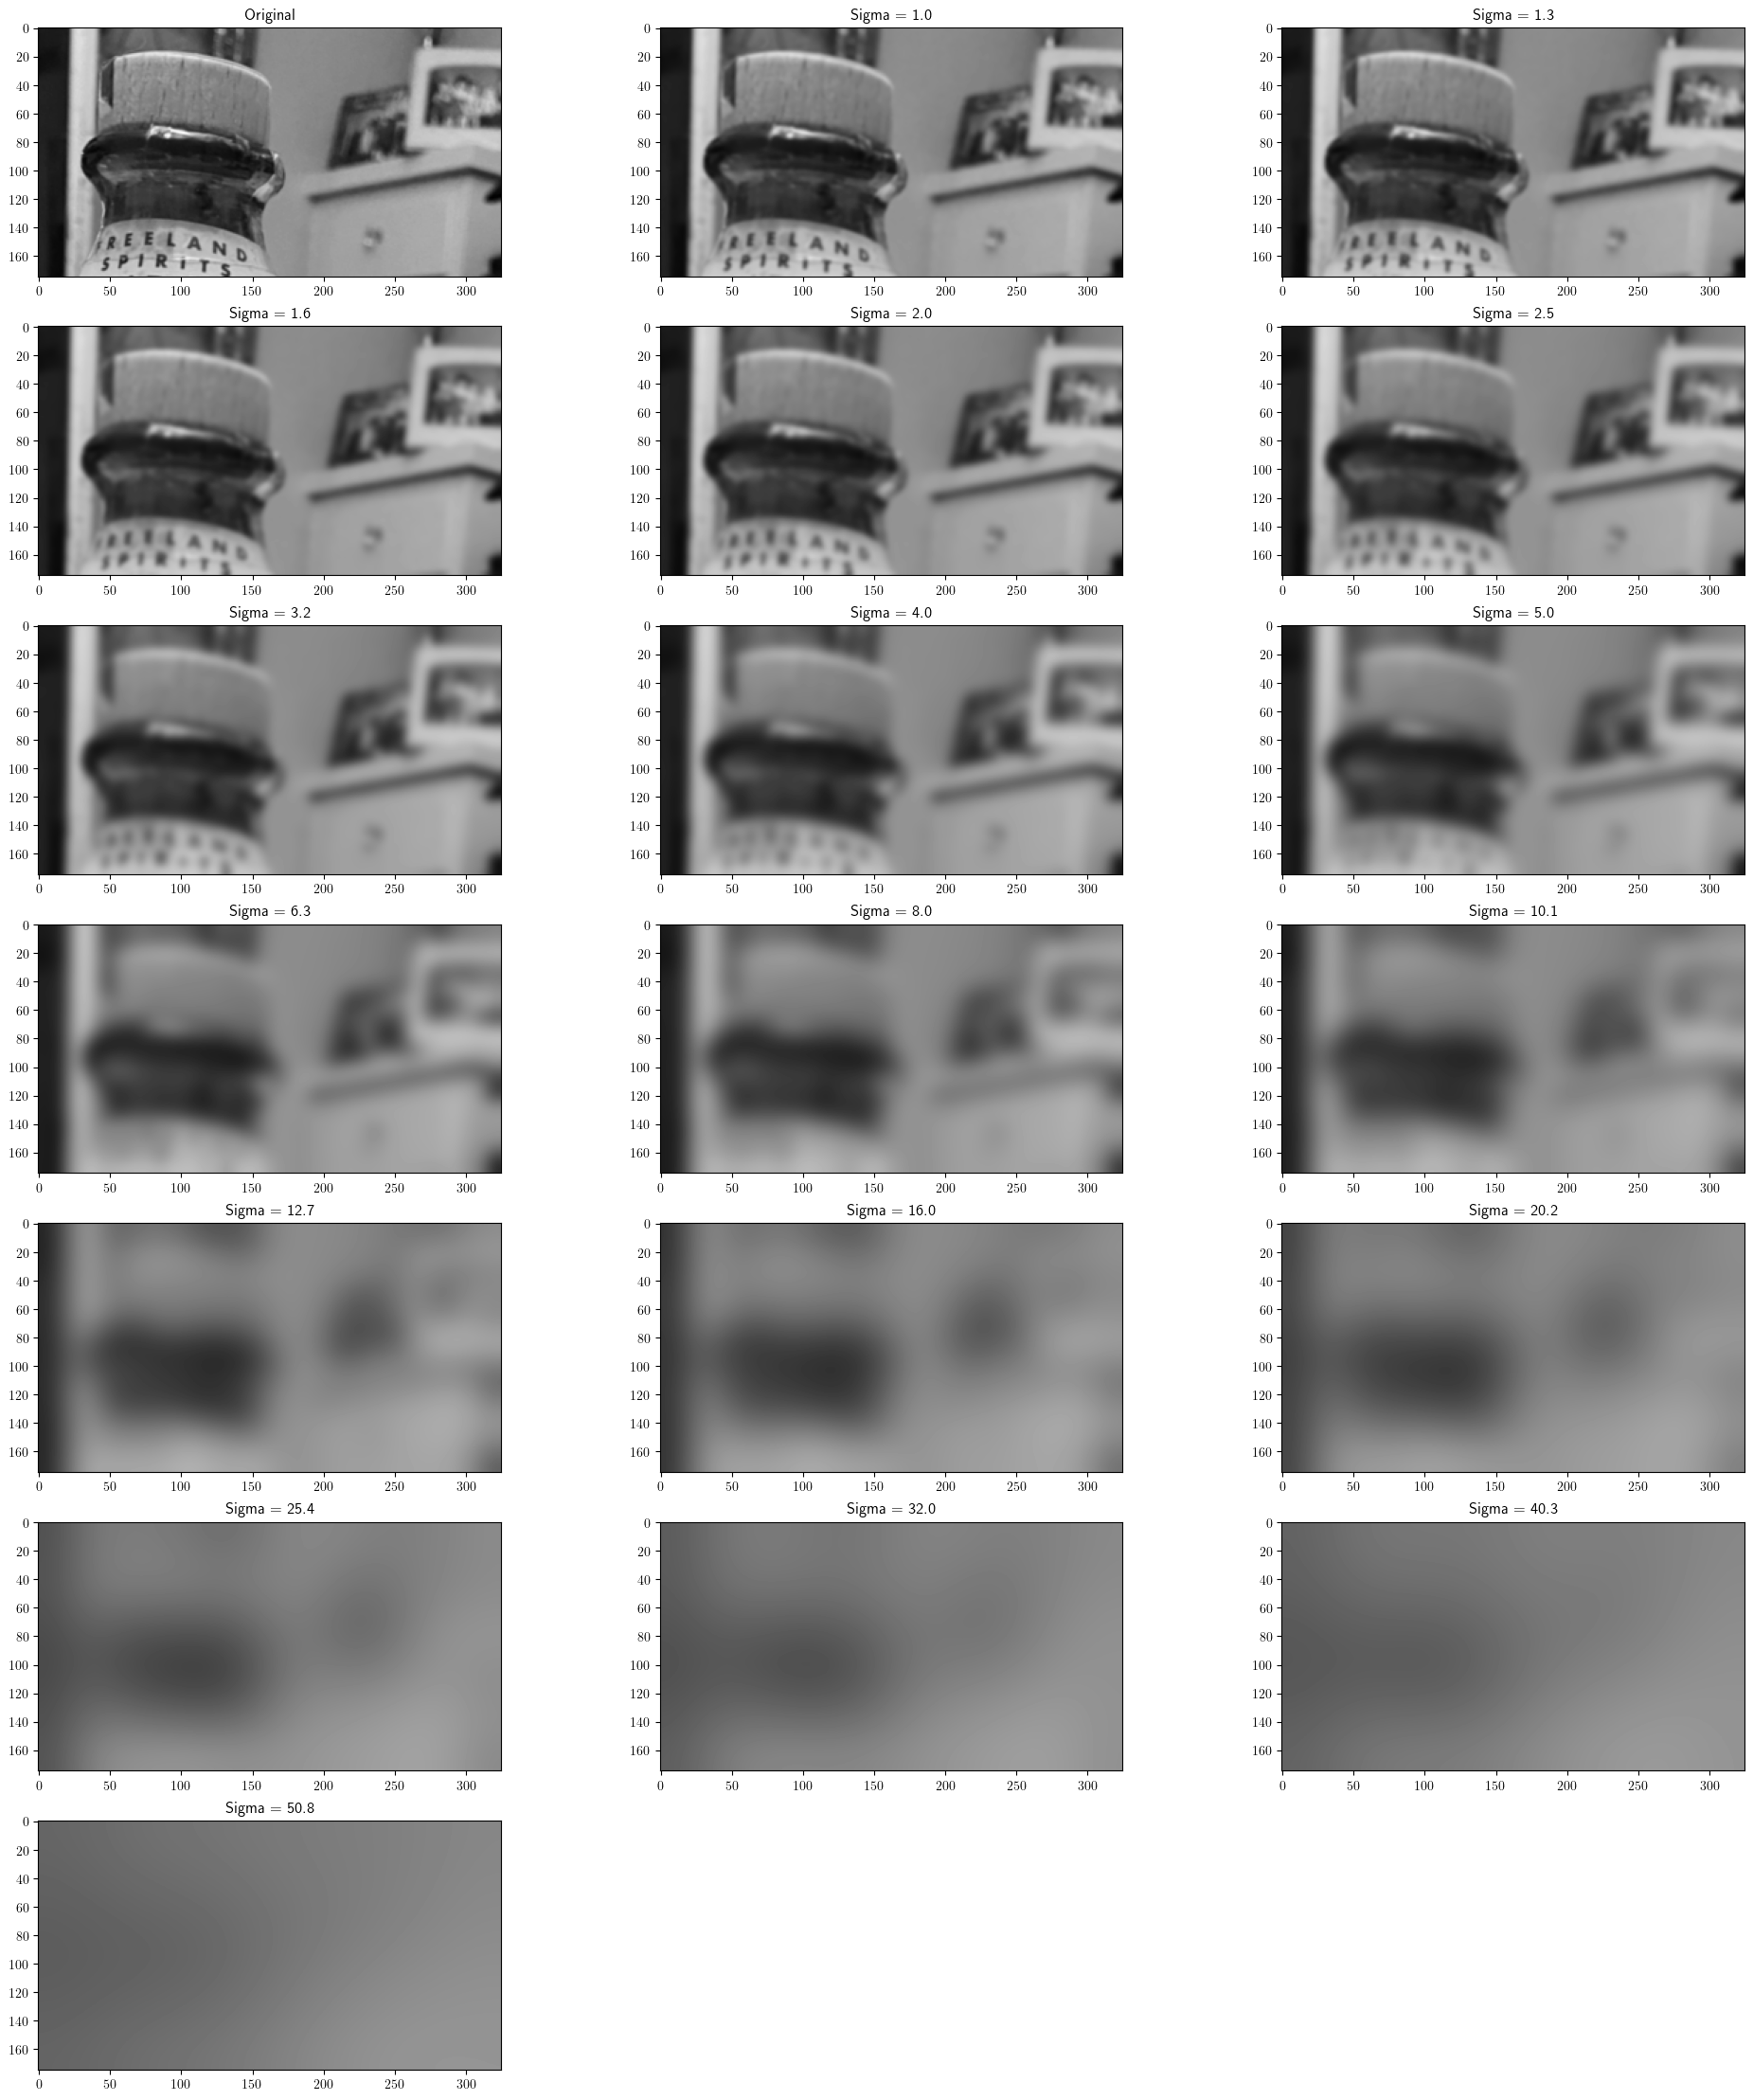

In [4]:
#%% Gaussian Blur
nIntervalsPerOctave = 3 # Represented as s in 2004.Lowe, p. 94

octaveSteps = np.logspace(0,np.log10(2),nIntervalsPerOctave+1)
octaveSteps = octaveSteps[:-1]
nOctaves = 6

sigmas = list()
for cOctave in range(nOctaves):
    for octaveStep in octaveSteps:
        sigma = 2.0**(cOctave)*octaveStep
        sigmas.append(sigma)      
        
imageStack = list()
for sigma in sigmas:
    #kw = max(3,int(sigma*10)+int(sigma*10)%2+3)
    kw = max(3,int(sigma*4*2)+int(sigma*4*2)%2+1)
    image = cv.GaussianBlur(imageGray, (kw,kw), sigmaX=sigma)
    imageStack.append(image)        
        
nAxesColumns = 3 
nAxesRows    = int(np.ceil((len(sigmas)+1)/nAxesColumns))
scaleFactor  = 4

figure = plt.figure(1)
figure.set_size_inches(nAxesColumns*2.0*scaleFactor,nAxesRows*scaleFactor)
figure.clf()

axes = figure.add_subplot(nAxesRows,nAxesColumns,1)
axes.imshow(imageGray,cmap='gray', vmin=0, vmax=1)
axes.set_title('Original')

for cImage,image in enumerate(imageStack):
    #if cImage+2>len(imageStack):
    #    break
    axes = figure.add_subplot(nAxesRows,nAxesColumns,cImage+2)
    axes.imshow(image,cmap='gray', vmin=0, vmax=1)
    axes.set_title('Sigma = %3.1f' % sigmas[cImage])

plt.show()


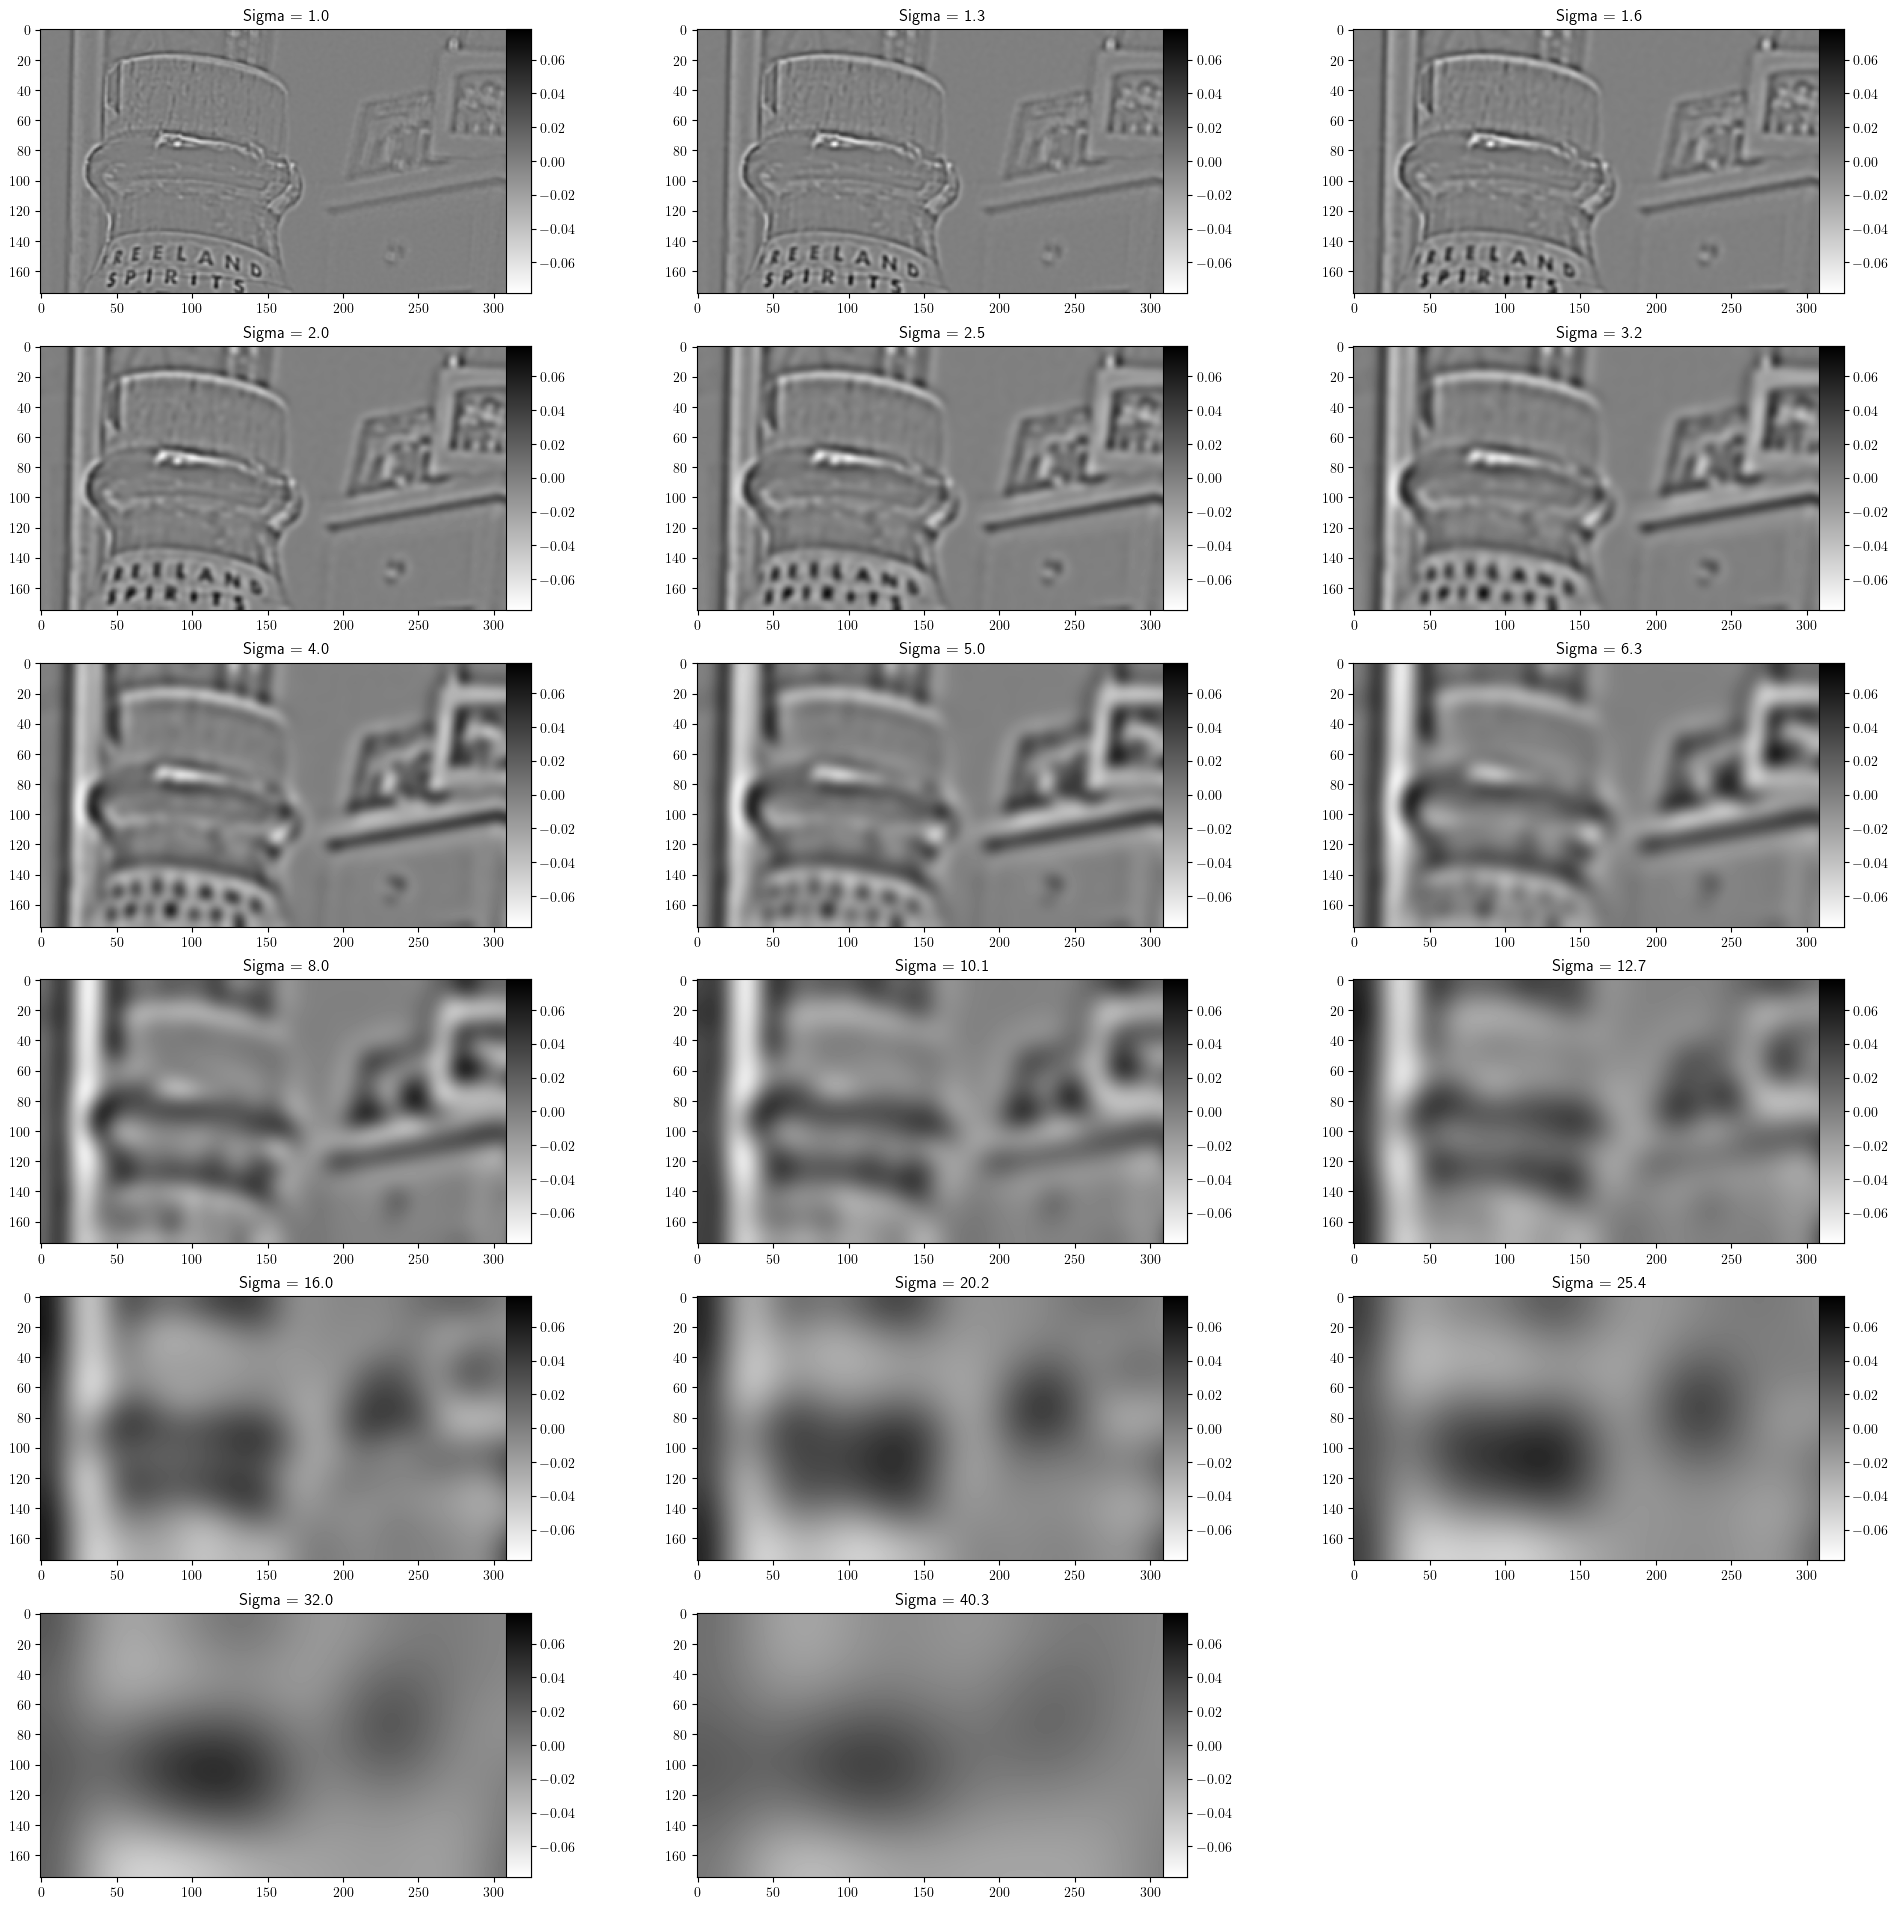

In [5]:
#%% Gaussian Differences
vMin = -20/256
vMax =  20/256

nAxesColumns = 3
nAxesRows    = int(np.ceil((len(imageStack)-1)/nAxesColumns))

figure = plt.figure(1)
figure.set_size_inches(nAxesColumns*2.0*scaleFactor,nAxesRows*scaleFactor)
figure.clf()

gaussianDifferences = list()
for cImage in range(len(imageStack)-1):
    axes = figure.add_subplot(nAxesRows,nAxesColumns,cImage+1)
    image   = imageStack[cImage  ]
    imageUp = imageStack[cImage+1]
    DG = imageUp - image
    axes.imshow(DG,cmap='gray_r',vmin=vMin,vmax=vMax)
    axes.set_title('Sigma = %3.1f' % sigmas[cImage])
    pcv.AddColorbar(axes,colorMap='gray_r')
    gaussianDifferences.append(DG)

plt.show()

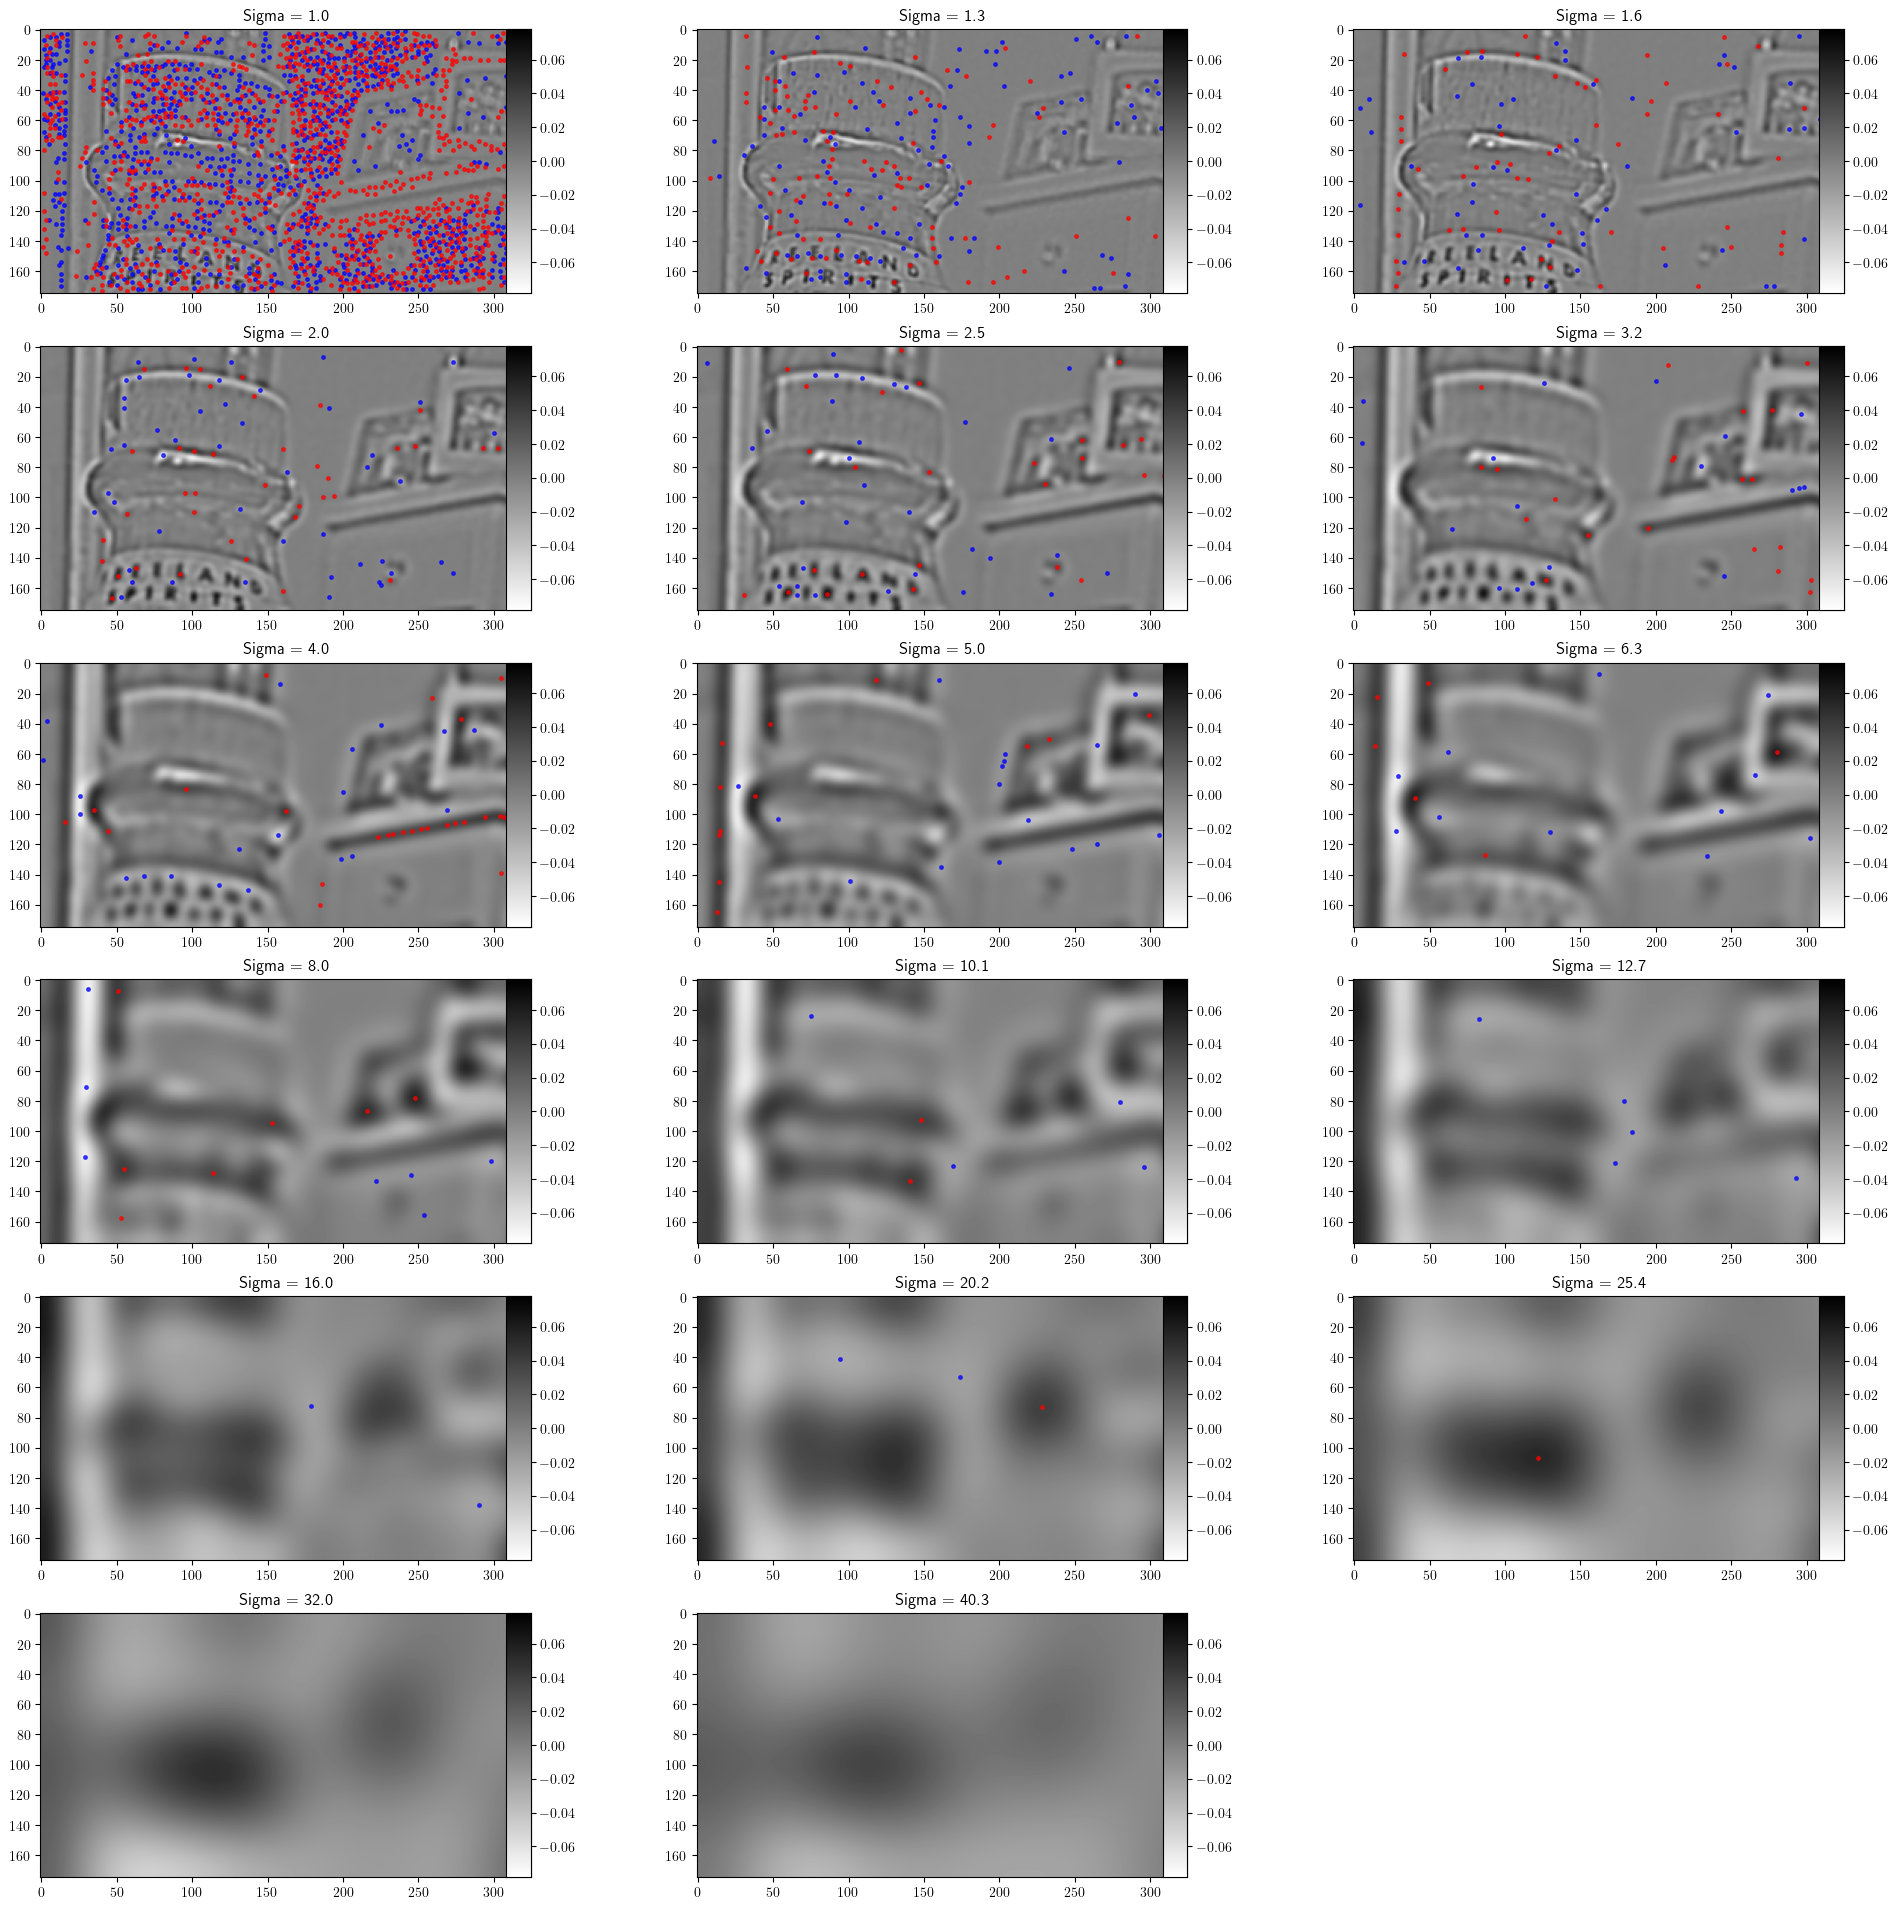

In [6]:
#%% Extrema Detection
nAxesColumns = 3
nAxesRows    = int(np.ceil((len(gaussianDifferences))/nAxesColumns))

figure = plt.figure(3)
figure.set_size_inches(nAxesColumns*2.0*scaleFactor,nAxesRows*scaleFactor)
figure.clf()

keypoints = list()
for cDG,DG in enumerate(gaussianDifferences):       
    maxima = np.zeros_like(cDG)
    
    nRows     = DG.shape[0]
    nColumns  = DG.shape[1]
    #nChannels = layer.shape[2]
       
    maxima = list()
    minima = list()
    for cRow in range(1,nRows-1):
        for cColumn in range(1,nColumns-1):
            local = np.ones((3,3,3))*np.nan # Fill in with NaNs to skip over layers that are unavailable easily

            if cDG>0: # Is the lower layer (smaller sigma) available?
                image = gaussianDifferences[cDG-1]
                patch = image[cRow-1:cRow+2,cColumn-1:cColumn+2] # Grab the patch at this layer
                local[0,:,:] = patch # Assign to layer 0 of 3x3x3 array

            image = gaussianDifferences[cDG]
            patch = image[cRow-1:cRow+2,cColumn-1:cColumn+2]
            local[1,:,:] = patch
            
            if cDG<len(gaussianDifferences)-1:
                image = gaussianDifferences[cDG+1]
                patch = image[cRow-1:cRow+2,cColumn-1:cColumn+2]
                local[2,:,:] = patch
            
            localWithoutCenter = np.delete(local, 13)
            localValid = localWithoutCenter[~np.isnan(localWithoutCenter)]
            if local[1,1,1]>np.max(localValid):
                maxima.append((cRow,cColumn))
            if local[1,1,1]<np.min(localValid):
                minima.append((cRow,cColumn))
    kps = maxima + minima # All keypoints at this scale
    keypoints.append(kps)
    axes = figure.add_subplot(nAxesRows,nAxesColumns,cDG+1)
    axes.imshow(DG,cmap='gray_r',vmin=vMin,vmax=vMax)
    for pt in minima:
        axes.plot(pt[1],pt[0],marker='.',color='b',markersize=5,alpha=0.7) # Minima
    for pt in maxima:
        axes.plot(pt[1],pt[0],marker='.',color='r',markersize=5,alpha=0.7) # Maxima
    axes.set_title('Sigma = %3.1f' % sigmas[cDG])
    pcv.AddColorbar(axes,colorMap='gray_r')
plt.show()

### Local Extrema Detection
* Goal: find local extrema in $D(x,y,\sigma)$
    * Extrema include minima and maxima
* Each sample point has eight spatial neighbors
* But then there are neighbors at different scales 
    * Above and below in the stack
* Key idea: can conceive of images with three independent variables
    * Spatial coordinates (rows and columns)
    * Scale ($\sigma$)
* SIFT only selects maxima relative to all 9 (higher scale) + 8 + 9 (lower scale) = 26 neighbors
    * Note that at the start of each octave, there is no lower layer
    * Since $2\sigma$ is represented at both the top of the octave, and the next octave, presumably you would skip the first layer in the higher octave since it would otherwise be redundant and would be missing the bottom layer
    * However, can't do this with the lowest level. Presumably in that case there are only 9 (higher scale) + 8 = 17 neighbors

### Sample Rate of Scale
* Question
    * How densely sampled should the image be relative to the scale ($\sigma$)?
    * How densely should we sample across scale ($s$)?
* There is no minimum spacing that will detect all extrema
* Extrema can be arbitrarily close together
* Conceptually
    * A circle clearly has a single maximum
    * An elongated ellipse has two
    * As we adjust the ratio of the major to minor axes closer to 1, the maxima can become arbitrarily close
* Engineering tradeoff
    * Computational efficiency
    * Completeness (number of detected extrema)
* Note, however, that extrema close to one another are ``unstable''
* Stability
    * Means that points are detectable after geometric transformations and changes in illumination
* Lowe's experiment
    * Varying number of scales per octave
    * Presumably this was the variable $s$ where $k=^{1/s}$
    * Random rotation
    * Random scaling between 0.2 and 0.9
    * Resampled image (details left out)
    * 1% image noise (scaled 0 to 1)
        * Equivalent to a little less than 6 bits of accuracy
    * What is a match
        * Keypoint detected in original, also detected at expected location in modified image
        * Within $\sqrt{2}$ of correct scale
        * Within $\sigma$ of the correct spatial location (pixels) where $\sigma$ is the smaller of the two Gaussians used to calculate the difference of Gaussian
    * See Figure 3

#### Results and conclusion
* Best at $s=3$ scales per octave
* Why was there a local maximum?
    * If too coarse, difference of Gaussians doesn't represent Laplacian
        * Differences are over too big of change of scale
    * If too fine, features detected are not stable
        * Therefore less likely to be detected in transformed images
        * See second figure for number of keypoints per image detected
* However, may care less about repeatability
    * In some applications, performance increases with number of keypoints detected
    * Lowe states this is true for object detection
    * But this comes at a cost of computation
    * And there are diminishing returns in terms of quality
* Primary Tradeoff
    * Computation vs performance
* Key conclusion
    * Can detect most stable keypoints with a coarse sampling of scales
    * Good news

### Sample Rate of Space
* How fine should the spatial sampling be relative to $\sigma$?
* Engineering tradeoff
    * Rate of detection
    * Computation
    * Lowe states this is between sample rate and rate of detection, but this isn't right. Higher sample rates is not necessarily bad.
* Thought Experiment
    * Suppose we start with the raw image 
    * How much smoothing (if any) should we apply before building out the pyramid?
    * What is the $\sigma$ we apply to the original image?
    * Repeatability only increases with $\sigma$
    * Lowe chose $\sigma=1.6$ as the point of diminishing returns 
    * See Figure 4
    * However, discards high-spatial frequencies
    * To "fix" this, they upsample the image by $2\times$ before processing
    * Doubles the size of the original image
    * For some reason, they used "linear interpolation"
        * No justification given
        * Perhaps prioritized computational efficiency
        * May not matter much
    * Suppose original image had a blur of $\sigma = 0.5$
        * This is interesting
        * Why would you want an image to be blurred at all?
        * Answer: to prevent aliasing
    * If so, the doubled image has a $\sigma = 1.0$ relative to new pixel spacing
        * Ignoring the problems with linear interpolation
    * This means the additional Gaussian blur of $\sigma = 1.6$ hardly blurs the image any further
    * Little additional smoothing is needed for the first octave of scale space
    * Lowe reports this increases the number of stable keypoints by $4\times$!
        * But no further improvements with larger expansion factor
    

### Keypoint Localization
* Browne and Lowe (2002) suggeste a means of improving localization
* Fit a quadratic

\begin{align}
    D(x) &= D + \frac{\partial D}{\partial x} x + \frac{1}{2} x^{T} \frac{\partial^2 D}{\partial x^2} x
    \hspace{100em}
\end{align}

* evaluated at a "sample point" 
* presumably location of an extrema


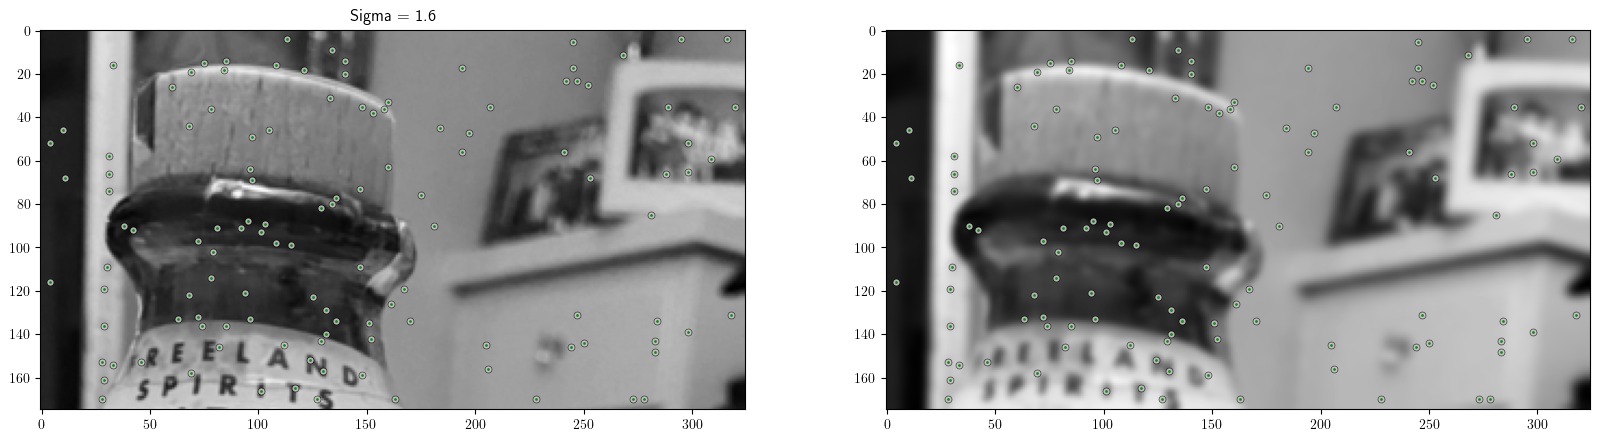

In [23]:
#%% Plot Keypoints at 3rd level on original image

level = 2

image = imageStack[level]

figure = plt.figure(3)
figure.set_size_inches(20,20)
figure.clf()

axes = figure.add_subplot(1,2,1)
axes.imshow(imageGray,cmap='gray')
for pt in keypoints[level]:
     axes.plot(pt[1],pt[0],marker='.',color='k',markersize=11,alpha=0.7,markeredgewidth=0)
     axes.plot(pt[1],pt[0],marker='.',color='w',markersize= 9,alpha=0.7,markeredgewidth=0)  
     axes.plot(pt[1],pt[0],marker='.',color='g',markersize= 4,alpha=0.9,markeredgewidth=0) 
axes.set_title('Sigma = %3.1f' % sigmas[level])

axes = figure.add_subplot(1,2,2)
axes.imshow(image,cmap='gray')
for pt in keypoints[level]:
     axes.plot(pt[1],pt[0],marker='.',color='k',markersize=11,alpha=0.7,markeredgewidth=0)
     axes.plot(pt[1],pt[0],marker='.',color='w',markersize= 9,alpha=0.7,markeredgewidth=0)  
     axes.plot(pt[1],pt[0],marker='.',color='g',markersize= 4,alpha=0.9,markeredgewidth=0)

plt.show()

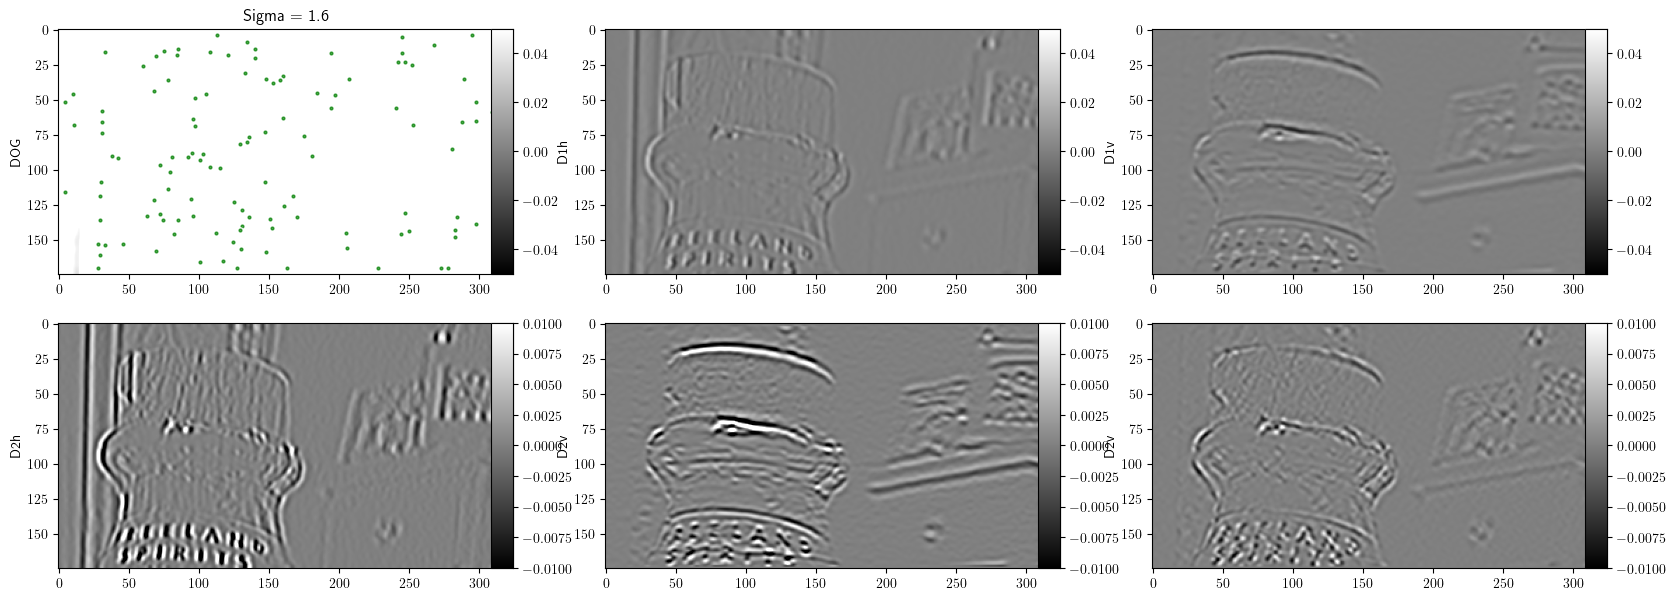

In [8]:
#%% Plot the Derivatives of the Difference of Gaussians
kernelh = np.array([[-1.0,0.0,1.0]])/2.0 # kernelh is sensitive to changes along the horizontal (col) axis
kernelv = np.transpose(kernelh)          # kernelv is sensitive to changes along the vertical (row) axis

dog = gaussianDifferences[level]

dogD1h    = cv.filter2D(dog   ,cv.CV_32F,kernelh) # 2D "Convolution" With the Horizontal Kernel
dogD1v    = cv.filter2D(dog   ,cv.CV_32F,kernelv) # 2D "Convolution" With the Vertical Kernel
dogD1hD1v = cv.filter2D(dogD1h,cv.CV_32F,kernelv)
dogD2h    = cv.filter2D(dogD1h,cv.CV_32F,kernelh) # 2D "Convolution" With the Horizontal Kernel
dogD2v    = cv.filter2D(dogD1v,cv.CV_32F,kernelv) # 2D "Convolution" With the Vertical Kernel 

figure = plt.figure(3)
figure.set_size_inches(20,7)
figure.clf()

axes = figure.add_subplot(2,3,1)
axes.imshow(image,cmap='gray',vmin=-0.05,vmax=0.05)
for pt in keypoints[level]:
     axes.plot(pt[1],pt[0],marker='.',color='w',markersize=8,alpha=0.7)   
     axes.plot(pt[1],pt[0],marker='.',color='g',markersize=4,alpha=0.7)  
axes.set_title('Sigma = %3.1f' % sigmas[level])
axes.set_ylabel('DOG')
pcv.AddColorbar(axes)

axes = figure.add_subplot(2,3,2)
axes.imshow(dogD1h,cmap='gray',vmin=-0.05,vmax=0.05)
axes.set_ylabel('D1h')
pcv.AddColorbar(axes)

axes = figure.add_subplot(2,3,3)
axes.imshow(dogD1v,cmap='gray',vmin=-0.05,vmax=0.05)
axes.set_ylabel('D1v')
pcv.AddColorbar(axes)

axes = figure.add_subplot(2,3,4)
axes.imshow(dogD2h,cmap='gray',vmin=-0.01,vmax=0.01)
axes.set_ylabel('D2h')
pcv.AddColorbar(axes)

axes = figure.add_subplot(2,3,5)
axes.imshow(dogD2v,cmap='gray',vmin=-0.01,vmax=0.01)
axes.set_ylabel('D2v')
pcv.AddColorbar(axes)

axes = figure.add_subplot(2,3,6)
axes.imshow(dogD1hD1v,cmap='gray',vmin=-0.01,vmax=0.01)
axes.set_ylabel('D2v')
pcv.AddColorbar(axes)

plt.show()

In [9]:
#%% Adjust and localize Keypoints
nKeypointsPrint = 10
DThreshold = 0.03 # Only include extremea with a D.0.03, 2004.Lowe, Page 98

image = gaussianDifferences[level]

keypointsLocalized = list()
H = np.zeros((2,2))
g = np.zeros((2,1))
for cpt,pt in enumerate(keypoints[level]): 
    x = np.array([[pt[1],pt[0]]]).T # Keypoints are stored as (y,x) = (r,c)
    if cpt<nKeypointsPrint:
        print('Keypoint %d Image:%5.3f' % (cpt,image[pt[0],pt[1]]))
    movedKeypoint = True
    cMoves = 0
    xNew = x
    while movedKeypoint:    
        r = x[1,0] # r = y = x[1,0]
        c = x[0,0] # c = x = x[0,0]
        H[0,0] = dogD2h   [r,c] # Second derivative with respect to x
        H[1,1] = dogD2v   [r,c] # Second derivative with respect to y
        H[1,0] = dogD1hD1v[r,c] # Partial derivatives with respect to x and y
        H[0,1] = dogD1hD1v[r,c] # Partial derivatives with respect to x and y
        
        determinant = H[0,0]*H[1,1] - (H[0,1]**2)
        if determinant<0.00000001: # Determinant is essentially zero, singular matrix
            D = 0 # Don't include this point
            break        
        g[0]   = dogD1h   [r,c] # First derivative with respect to x
        g[1]   = dogD1v   [r,c] # First derivative with respect to y
        xDelta = -np.linalg.inv(H) @ g # Matrix multiplication, equation (3) in Lowe
        if abs(xDelta).max()<0.5:
            movedKeypoint = False
        if abs(xDelta).max()>2: # Only move to a new keypoint if the estimated maximum is less than 2 pixels away in any direction
            movedKeypoint = False  # Stop searching for a better point
        else: # Okay to use localized point otherwise
            xNew = x + xDelta
            D    = image[r,c] + 0.5*g.T @ xDelta
        if cpt<nKeypointsPrint:
            print('  (%6.2f,%6.2f) + (%6.2f,%6.2f) -> (%6.2f,%6.2f): D:%5.3f -> %5.3f' % (x[0],x[1],xDelta[0],xDelta[1],xNew[0],xNew[1],image[r,c],D)) # Keypoints stored as (y,x) = (r,c)            
        cMoves += 1
        if cMoves > 2:
            break
        x[0,0] = round(xNew[0,0]) # Repeat loop at new center
        x[1,0] = round(xNew[1,0])        
    if abs(D)>DThreshold: 
        keypointsLocalized.append((xNew[1,0],xNew[0,0]))

print('Original  Keypoints: %d' % len(keypoints[level]))
print('Localized Keypoints: %d' % len(keypointsLocalized))

Keypoint 0 Image:0.002
  (113.00,  4.00) + (  0.38,  0.19) -> (113.38,  4.19): D:0.002 -> 0.002
Keypoint 1 Image:0.001
  (316.00,  4.00) + ( -0.39,  0.04) -> (315.61,  4.04): D:0.001 -> 0.001
Keypoint 2 Image:0.001
  (245.00,  5.00) + (  0.10, -0.41) -> (245.10,  4.59): D:0.001 -> 0.001
Keypoint 3 Image:0.025
  (268.00, 11.00) + (  0.24, -0.16) -> (268.24, 10.84): D:0.025 -> 0.025
Keypoint 4 Image:0.030
  ( 85.00, 14.00) + (  0.42,  0.19) -> ( 85.42, 14.19): D:0.030 -> 0.030
Keypoint 5 Image:0.024
  ( 75.00, 15.00) + ( 19.27, -4.03) -> ( 75.00, 15.00): D:0.024 -> 0.030
Keypoint 6 Image:0.002
  ( 33.00, 16.00) + (  0.15,  0.45) -> ( 33.15, 16.45): D:0.002 -> 0.002
Keypoint 7 Image:0.024
  (108.00, 16.00) + ( -0.85, -0.30) -> (107.15, 15.70): D:0.024 -> 0.025
  (107.00, 16.00) + ( -0.38, -0.38) -> (106.62, 15.62): D:0.024 -> 0.025
Keypoint 8 Image:0.001
  (194.00, 17.00) + (  0.38, -0.08) -> (194.38, 16.92): D:0.001 -> 0.001
Keypoint 9 Image:0.037
  (121.00, 18.00) + ( -0.32, -0.30) -> (

/var/folders/nm/0ky94q191pz3b_t10sd5_nm00000gn/T/ipykernel_70133/2363363780.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('  (%6.2f,%6.2f) + (%6.2f,%6.2f) -> (%6.2f,%6.2f): D:%5.3f -> %5.3f' % (x[0],x[1],xDelta[0],xDelta[1],xNew[0],xNew[1],image[r,c],D)) # Keypoints stored as (y,x) = (r,c)


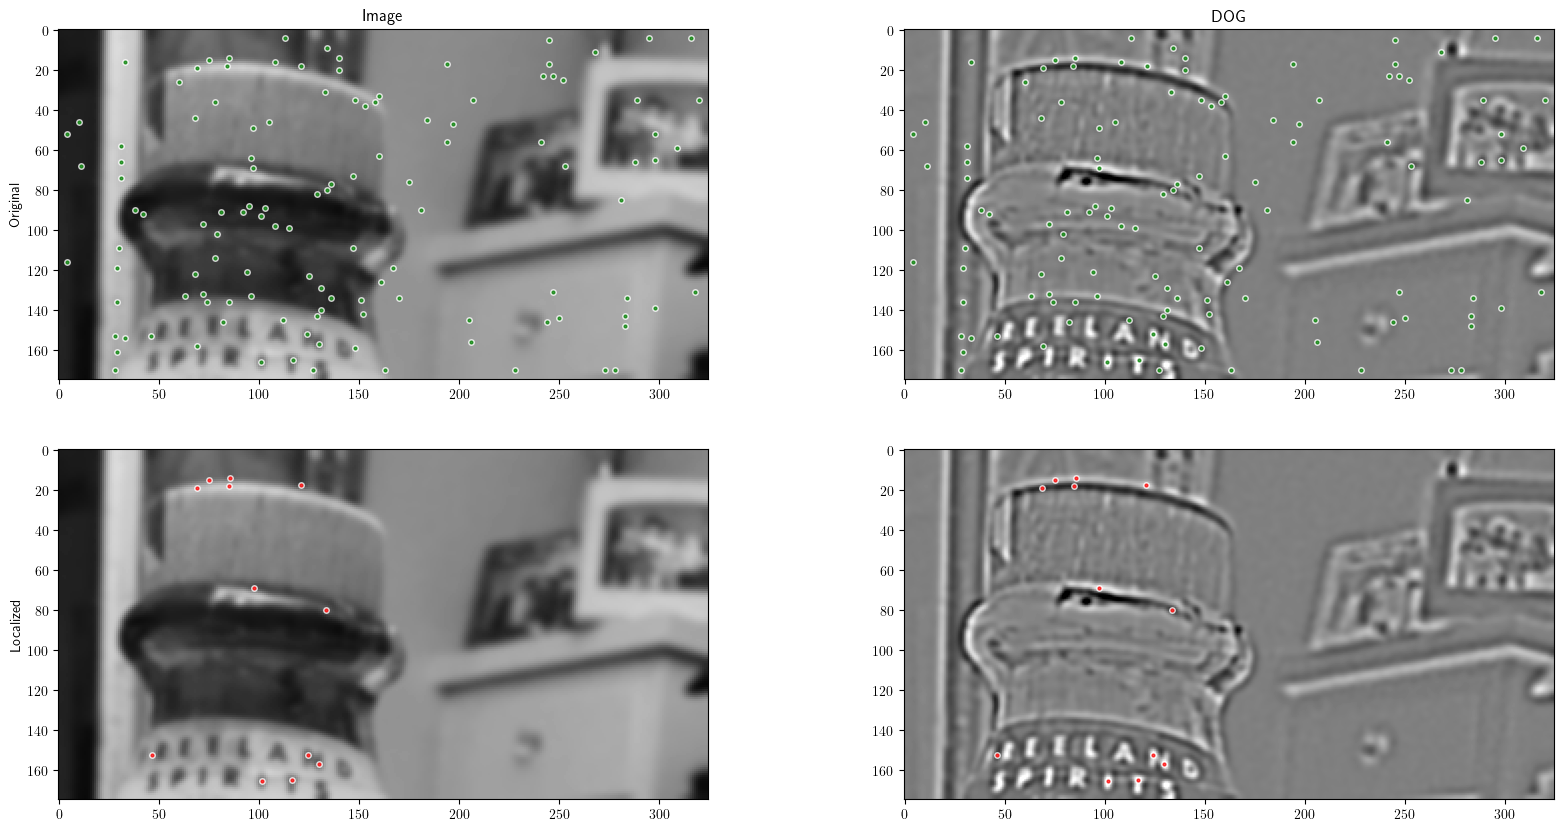

In [10]:
#%% Show keypoints before and after localizing keypoints
figure = plt.figure(3)
figure.set_size_inches(20,10)
figure.clf()

axes = figure.add_subplot(2,2,1)
axes.imshow(imageStack[level],cmap='gray',vmin=0,vmax=1)
for pt in keypoints[level]:
     axes.plot(pt[1],pt[0],marker='.',color='w',markersize=8,alpha=0.7)   
     axes.plot(pt[1],pt[0],marker='.',color='g',markersize=4,alpha=0.7)
axes.set_title('Sigma = %3.1f' % sigmas[level])
axes.set_title('Image')
axes.set_ylabel('Original')

axes = figure.add_subplot(2,2,2)
axes.imshow(gaussianDifferences[level],cmap='gray',vmin=-0.05,vmax=0.05)
for pt in keypoints[level]:
     axes.plot(pt[1],pt[0],marker='.',color='w',markersize=8,alpha=0.7)   
     axes.plot(pt[1],pt[0],marker='.',color='g',markersize=4,alpha=0.7)
axes.set_title('DOG')

axes = figure.add_subplot(2,2,3)
axes.imshow(imageStack[level],cmap='gray',vmin=0,vmax=1)
for pt in keypointsLocalized:
     axes.plot(pt[1],pt[0],marker='.',color='w',markersize=8,alpha=0.7)   
     axes.plot(pt[1],pt[0],marker='.',color='r',markersize=4,alpha=0.7)
axes.set_ylabel('Localized')

axes = figure.add_subplot(2,2,4)
axes.imshow(gaussianDifferences[level],cmap='gray',vmin=-0.05,vmax=0.05)
for pt in keypointsLocalized:
     axes.plot(pt[1],pt[0],marker='.',color='w',markersize=8,alpha=0.7)   
     axes.plot(pt[1],pt[0],marker='.',color='r',markersize=4,alpha=0.7)

plt.show()

### Elimination of Edges 

* Harris's approach
* Except, they used the Hessian matrix ($H$), instead of Harris' gradient outer product matrix
* Or did they?
    * They cite and give credit to Harris
    * But specifically for sidestepping the calculation of eigenvalues
* I think they probably correctly intended to use the Hessian matrix
* Unlike the earlier stage, this is applied to the image at some specific scale - not the difference of Gaussians

Let $\alpha$ be the largest eigenvalue and $\beta$ be the smaller one

\begin{align*}
    \mathrm{Tr}(H) &= D_{xx} + D_{yy} = \alpha + \beta\\
    \mathrm{Det}(H) &= D_{xx}D_{yy} - (D_{xy})^2 
    \hspace{100em}
\end{align*}

Further let 
\begin{align*}
    r &= \frac{\alpha}{\beta} &
    \alpha &= r\beta
    \hspace{100em}
\end{align*}

Then 
\begin{equation*}
\frac{\mathrm{Tr}(H)^2}{\mathrm{Det}(H)} 
    = \frac{(\alpha + \beta)^2}{\alpha \beta}
    = \frac{(r\beta + \beta)^2}{r \beta^2}
    = \frac{(r+1)^2}{r}
    \hspace{100em}
\end{equation*}

* This ratio increases monotonically with $r$
* Minimum when the two values are equal ($r=1$)
* Ratio of __principal curvatures__ is below $r$, just check 
    * Presumably _principal curvatures_ refers to the second derivative of the image in the directions of the Hessian eigenvectors

\begin{equation*}
    \frac{\mathrm{Tr}(H)^2}{\mathrm{Det}(H)} 
    \hspace{100em}
\end{equation*}

* They chose $r=10$
    * Eliminates keypoints with curvatures greater than 10
    * No rationale given for chosing this particular threshold

#### Note the differences with Harris
* Models
    * Harris
        * Based on a local linear model of the image surface
        * Works out to be a quadratic model for the error, but this is based on the image gradient alone
    * SIFT
        * Quadratic model of the image based on 2nd order Taylor series expansion
        * No error model
* Corners vs Edges/Lines
    * Harris 
        * Wanted to make sure that at corners a shift of an image patch would increase the error in all directions
        * Came up with a figure of merit that was computationally efficient
    * SIFT 
        * Only checks the ratio
        * The idea is that near edges one eigenvalue would be much larger than the other
        * The ratio could be low if there is little curvature in all directions
        * Relies on Laplacian to make sure the feature is distinctive (not too flat)
        * This means they are really just trying to rule out edges at this stage, unlike Harris

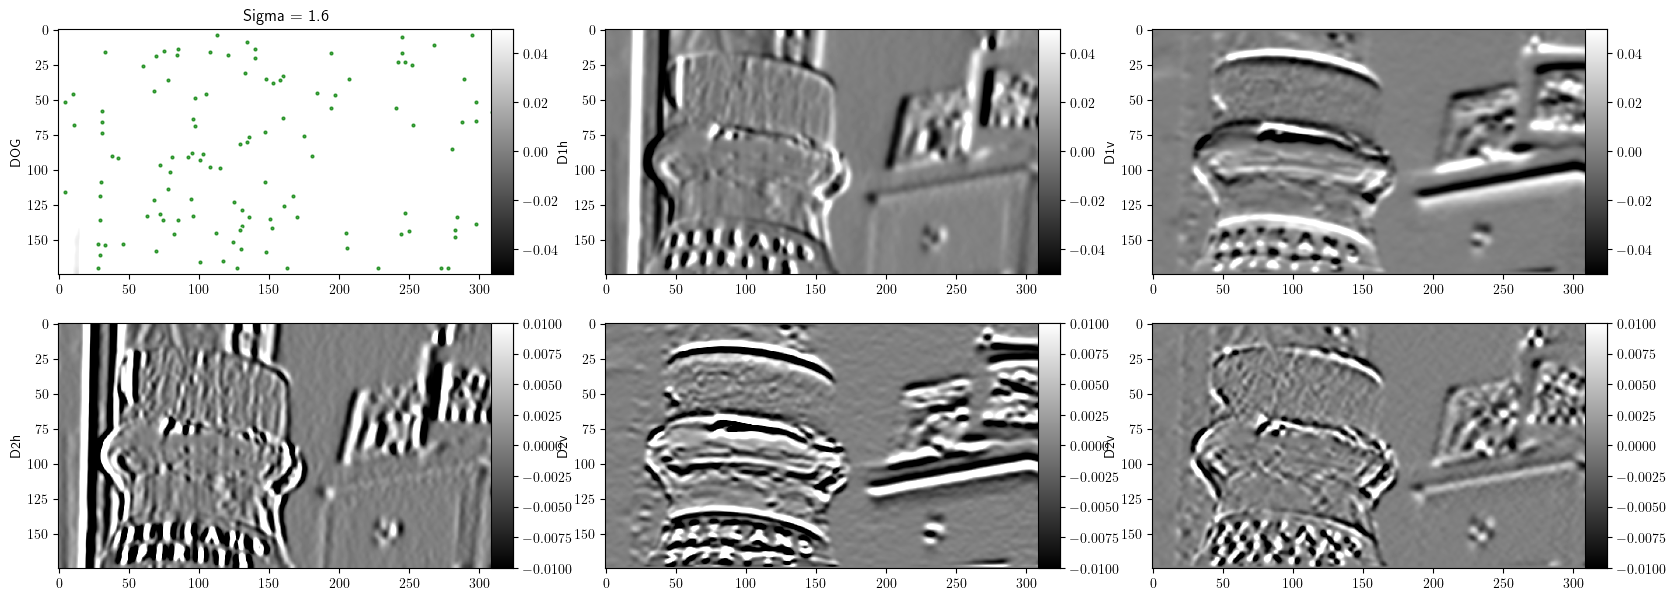

In [11]:
#%% Plot the Derivatives of the Image
kernelh = np.array([[-1.0,0.0,1.0]])/2.0 # kernelh is sensitive to changes along the horizontal (col) axis
kernelv = np.transpose(kernelh)          # kernelv is sensitive to changes along the vertical (row) axis

image = imageStack[level]

imageD1h    = cv.filter2D(image   ,cv.CV_32F,kernelh) # 2D "Convolution" With the Horizontal Kernel
imageD1v    = cv.filter2D(image   ,cv.CV_32F,kernelv) # 2D "Convolution" With the Vertical Kernel
imageD1hD1v = cv.filter2D(imageD1h,cv.CV_32F,kernelv)
imageD2h    = cv.filter2D(imageD1h,cv.CV_32F,kernelh) # 2D "Convolution" With the Horizontal Kernel
imageD2v    = cv.filter2D(imageD1v,cv.CV_32F,kernelv) # 2D "Convolution" With the Vertical Kernel 

figure = plt.figure(3)
figure.set_size_inches(20,7)
figure.clf()

axes = figure.add_subplot(2,3,1)
axes.imshow(image,cmap='gray',vmin=-0.05,vmax=0.05)
for pt in keypoints[level]:
     axes.plot(pt[1],pt[0],marker='.',color='w',markersize=8,alpha=0.7)   
     axes.plot(pt[1],pt[0],marker='.',color='g',markersize=4,alpha=0.7)  
axes.set_title('Sigma = %3.1f' % sigmas[level])
axes.set_ylabel('DOG')
pcv.AddColorbar(axes)

axes = figure.add_subplot(2,3,2)
axes.imshow(imageD1h,cmap='gray',vmin=-0.05,vmax=0.05)
axes.set_ylabel('D1h')
pcv.AddColorbar(axes)

axes = figure.add_subplot(2,3,3)
axes.imshow(imageD1v,cmap='gray',vmin=-0.05,vmax=0.05)
axes.set_ylabel('D1v')
pcv.AddColorbar(axes)

axes = figure.add_subplot(2,3,4)
axes.imshow(imageD2h,cmap='gray',vmin=-0.01,vmax=0.01)
axes.set_ylabel('D2h')
pcv.AddColorbar(axes)

axes = figure.add_subplot(2,3,5)
axes.imshow(imageD2v,cmap='gray',vmin=-0.01,vmax=0.01)
axes.set_ylabel('D2v')
pcv.AddColorbar(axes)

axes = figure.add_subplot(2,3,6)
axes.imshow(imageD1hD1v,cmap='gray',vmin=-0.01,vmax=0.01)
axes.set_ylabel('D2v')
pcv.AddColorbar(axes)

plt.show()

In [12]:
#%% Eliminate Keypoints Along Edges
r = 10

threshold = (r+1)**2/r

print('Threshold: %5.3f' % threshold)
keypointsDeedged = list()
H = np.zeros((2,2))
for cpt,pt in enumerate(keypointsLocalized): 
    r = round(pt[0]) # r = y
    c = round(pt[1]) # c = x
    H[0,0] = imageD2h   [r,c] # Second derivative with respect to x
    H[1,1] = imageD2v   [r,c] # Second derivative with respect to y
    H[1,0] = imageD1hD1v[r,c] # Partial derivatives with respect to x and y
    H[0,1] = imageD1hD1v[r,c] # Partial derivatives with respect to x and y
    
    trace = H[0,0] + H[1,1]
    determinant = H[0,0]*H[1,1] - (H[0,1]**2)
    statistic = (trace**2)/determinant
    if cpt<10:
        print('LKP %3d: tr=%5.3f det=%7.5f tr^2/det=%5.2f' % (cpt,trace,determinant,statistic)) # Keypoints stored as (y,x) = (r,c)

    if determinant<0: # If determinant is negative, found a saddle point and exclude (2004.Lowe, p.99)
        continue
    if statistic<threshold:
        keypointsDeedged.append(pt)

print('Original  Keypoints: %d' % len(keypoints[level]))
print('Localized Keypoints: %d' % len(keypointsLocalized))
print('De-edged  Keypoints: %d' % len(keypointsDeedged))


Threshold: 12.100
LKP   0: tr=0.042 det=0.00020 tr^2/det= 8.86
LKP   1: tr=0.033 det=-0.00001 tr^2/det=-74.92
LKP   2: tr=0.051 det=0.00047 tr^2/det= 5.57
LKP   3: tr=0.062 det=0.00025 tr^2/det=15.24
LKP   4: tr=0.080 det=0.00131 tr^2/det= 4.91
LKP   5: tr=0.085 det=0.00158 tr^2/det= 4.59
LKP   6: tr=0.090 det=0.00194 tr^2/det= 4.15
LKP   7: tr=0.097 det=0.00212 tr^2/det= 4.45
LKP   8: tr=-0.051 det=0.00004 tr^2/det=61.51
LKP   9: tr=-0.050 det=0.00010 tr^2/det=25.11
Original  Keypoints: 120
Localized Keypoints: 12
De-edged  Keypoints: 7


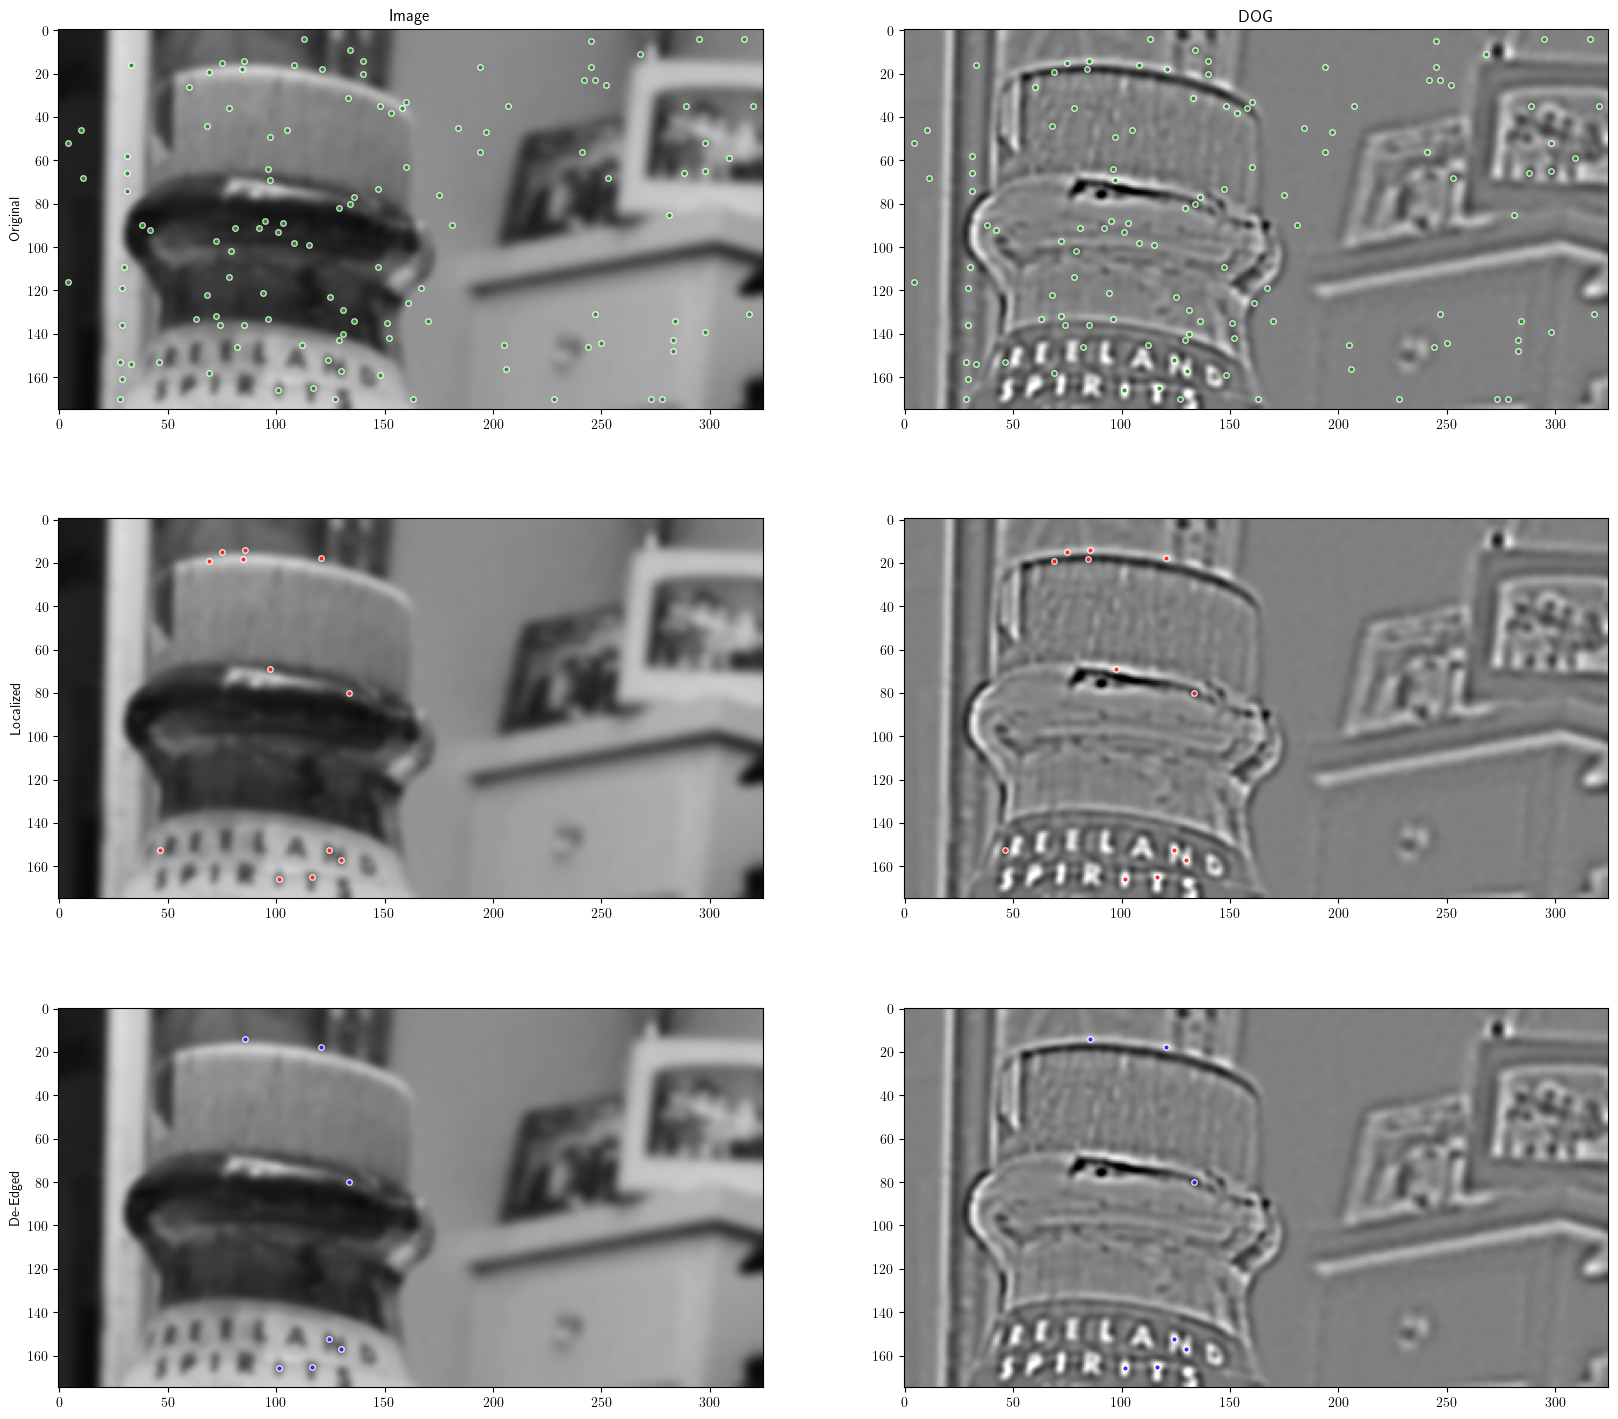

In [13]:
#%% Show keypoints before and after removing edges
figure = plt.figure(3)
figure.set_size_inches(20,18)
figure.clf()

axes = figure.add_subplot(3,2,1)
axes.imshow(imageStack[level],cmap='gray',vmin=0,vmax=1)
for pt in keypoints[level]:
     axes.plot(pt[1],pt[0],marker='.',color='w',markersize=8,alpha=0.7)   
     axes.plot(pt[1],pt[0],marker='.',color='g',markersize=4,alpha=0.7)
axes.set_title('Sigma = %3.1f' % sigmas[level])
axes.set_title('Image')
axes.set_ylabel('Original')

axes = figure.add_subplot(3,2,2)
axes.imshow(gaussianDifferences[level],cmap='gray',vmin=-0.05,vmax=0.05)
for pt in keypoints[level]:
     axes.plot(pt[1],pt[0],marker='.',color='w',markersize=8,alpha=0.7)   
     axes.plot(pt[1],pt[0],marker='.',color='g',markersize=4,alpha=0.7)
axes.set_title('DOG')

axes = figure.add_subplot(3,2,3)
axes.imshow(imageStack[level],cmap='gray',vmin=0,vmax=1)
for pt in keypointsLocalized:
     axes.plot(pt[1],pt[0],marker='.',color='w',markersize=8,alpha=0.7)   
     axes.plot(pt[1],pt[0],marker='.',color='r',markersize=4,alpha=0.7)
axes.set_ylabel('Localized')

axes = figure.add_subplot(3,2,4)
axes.imshow(gaussianDifferences[level],cmap='gray',vmin=-0.05,vmax=0.05)
for pt in keypointsLocalized:
     axes.plot(pt[1],pt[0],marker='.',color='w',markersize=8,alpha=0.7)   
     axes.plot(pt[1],pt[0],marker='.',color='r',markersize=4,alpha=0.7)

axes = figure.add_subplot(3,2,5)
axes.imshow(imageStack[level],cmap='gray',vmin=0,vmax=1)
for pt in keypointsDeedged:
     axes.plot(pt[1],pt[0],marker='.',color='w',markersize=8,alpha=0.7)   
     axes.plot(pt[1],pt[0],marker='.',color='b',markersize=4,alpha=0.7)
axes.set_ylabel('De-Edged')

axes = figure.add_subplot(3,2,6)
axes.imshow(gaussianDifferences[level],cmap='gray',vmin=-0.05,vmax=0.05)
for pt in keypointsDeedged:
     axes.plot(pt[1],pt[0],marker='.',color='w',markersize=8,alpha=0.7)   
     axes.plot(pt[1],pt[0],marker='.',color='b',markersize=4,alpha=0.7)

plt.show()

### Orientation Assignment (SIFT)

* If an orientation is assigned to each keypoint, keypoint descriptor can be relative to this orientation
* Makes the feature descriptors invariant to rotation
* Contrast with previous approach
    * Schmid and Mohr
    * Descriptors are based on rotation invariant measures
    * Limits descriptors much more
    * Discards image information since it doesn't require measures based on a consistent rotation
* They experimented with a number of techniques
* Optimization criterion: stability
* Scale of keypoint used to select Gaussian smoothed image
    * Makes everything scale invariant
* Calculate
    * Gradient magnitude $m(x,y)$
    * Orientation $\theta(x,y)$
    
\begin{align}
    m(x,y) &= \sqrt{\left(L(x+1,y) - L(x-1,y)\right)^2 + \left(L(x,y+1) - L(x,y-1)\right)^2}\\
    \theta(x,y) &= \tan^{-1}\frac{L(x,y+1) - L(x,y-1)}{L(x+1,y) - L(x-1,y)}
\end{align}

### Orientation Histogram
* Within a region (patch) around keypoint
* 36 bins covering 360 degrees
    * No rationale given for 36
    * 10 degree increments
    * Bin edges could be a problem
    * Book proposes a solution
    * Note there are other approaches that could be used for the density estimation
* Angle determines the bin
* Each point is weighted as the product of 
    * Gradient magnitude
    * Distance from keypoint center (Gaussian with $\sigma=1.5$ times the scale of the keypoint)
* The peak across the 36 bins determines the direction
    * Now each keypoint has a 
        * Pixel location $(x,y)$
        * Scale $(\sigma)$
        * Direction $(\theta)$
* Further, additional keypoints for each peak that is within 80% of the highest peak
    * No rationale given for 80% threshold
    * Multiple keypoints with identical locations and scales, but different directions
    * Empirically
        * 15% of points are assigned multiple orientations
        * Contributes to stability "significantly"
        * Note this provides a good rationale for this design decision
        * Clear, quantitative criterion
* Use a local parabola (quadratic) to fit the three bin centers nearest the peak to more accurately estimate the location

Angle Max:  -5.0  Vertex:  -2.5


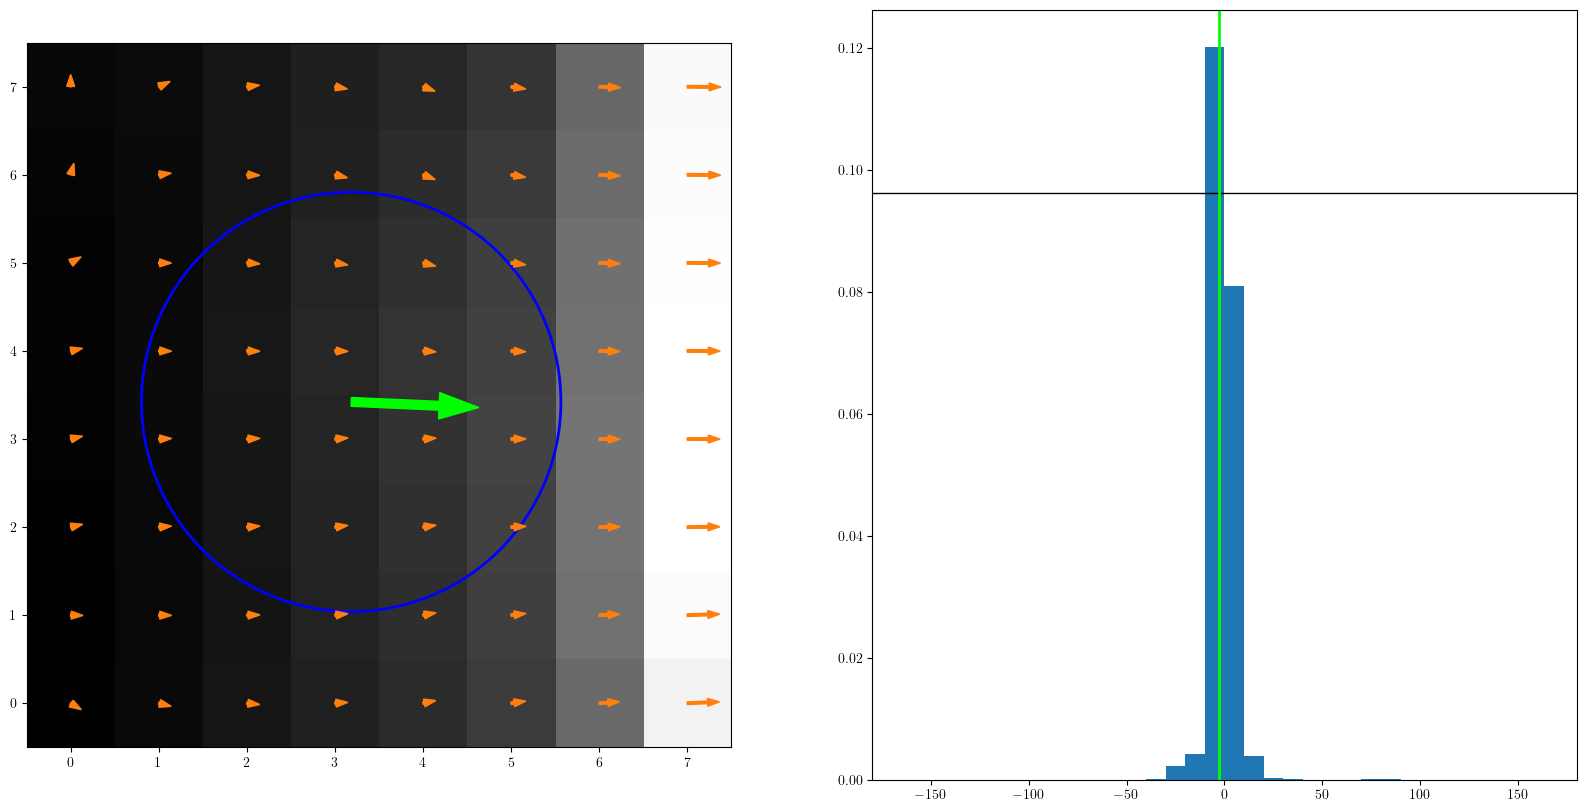

Angle Max:   5.0  Vertex:   5.0


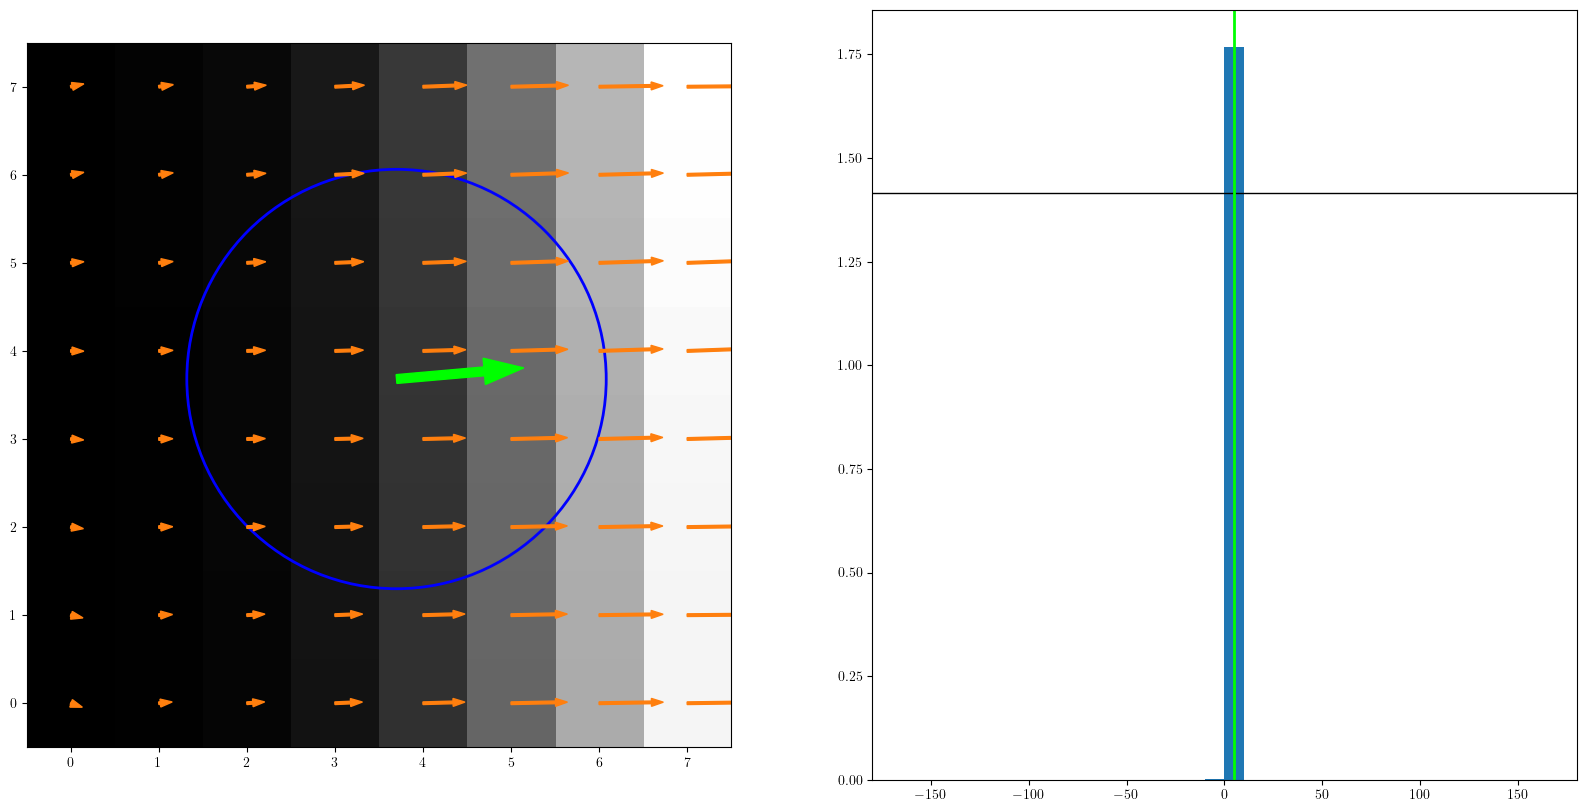

Angle Max: -55.0  Vertex: -55.1


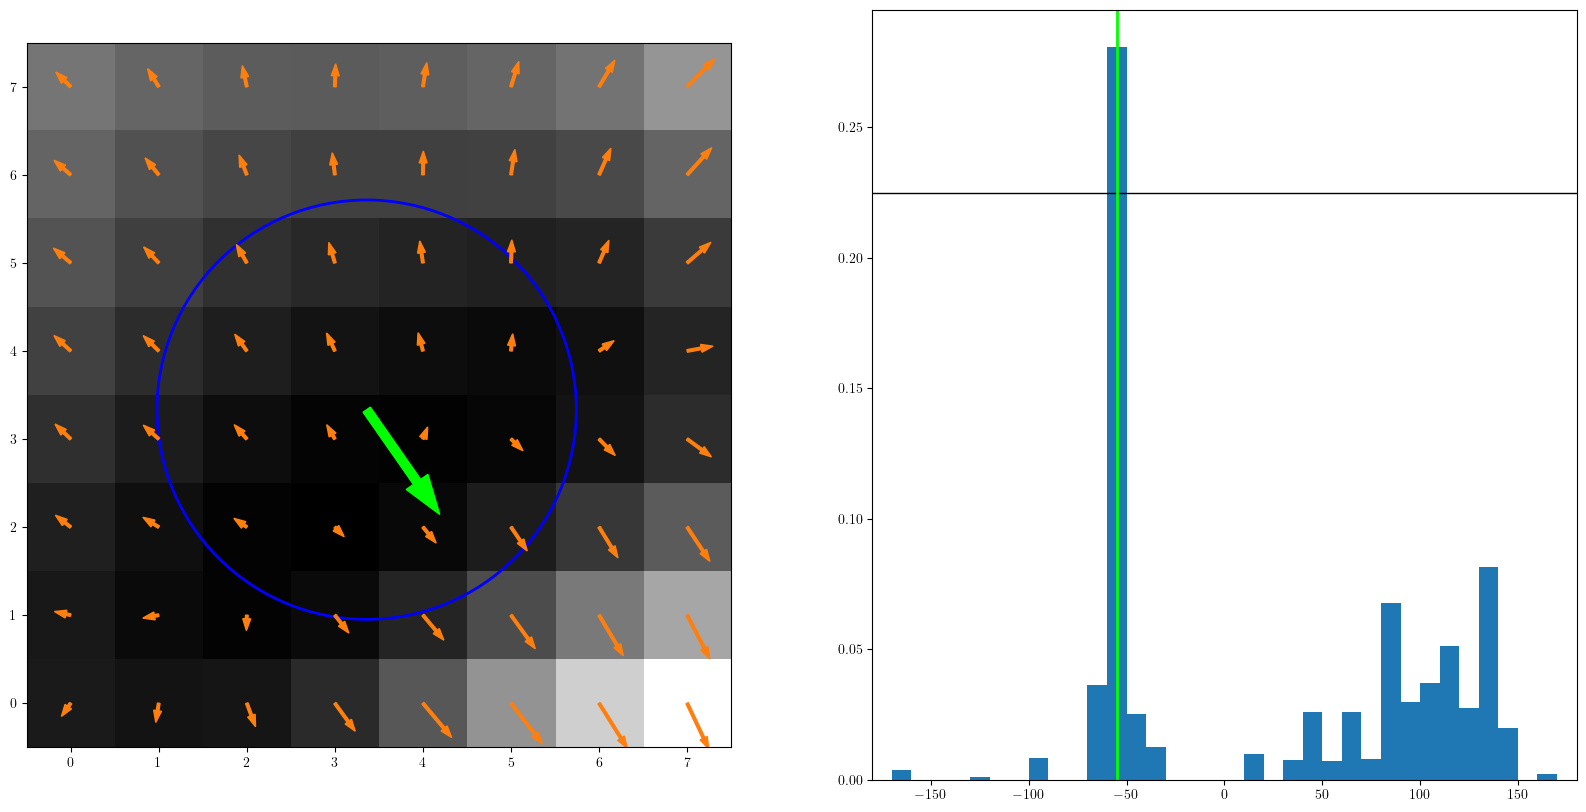

Angle Max:  25.0  Vertex:  26.8


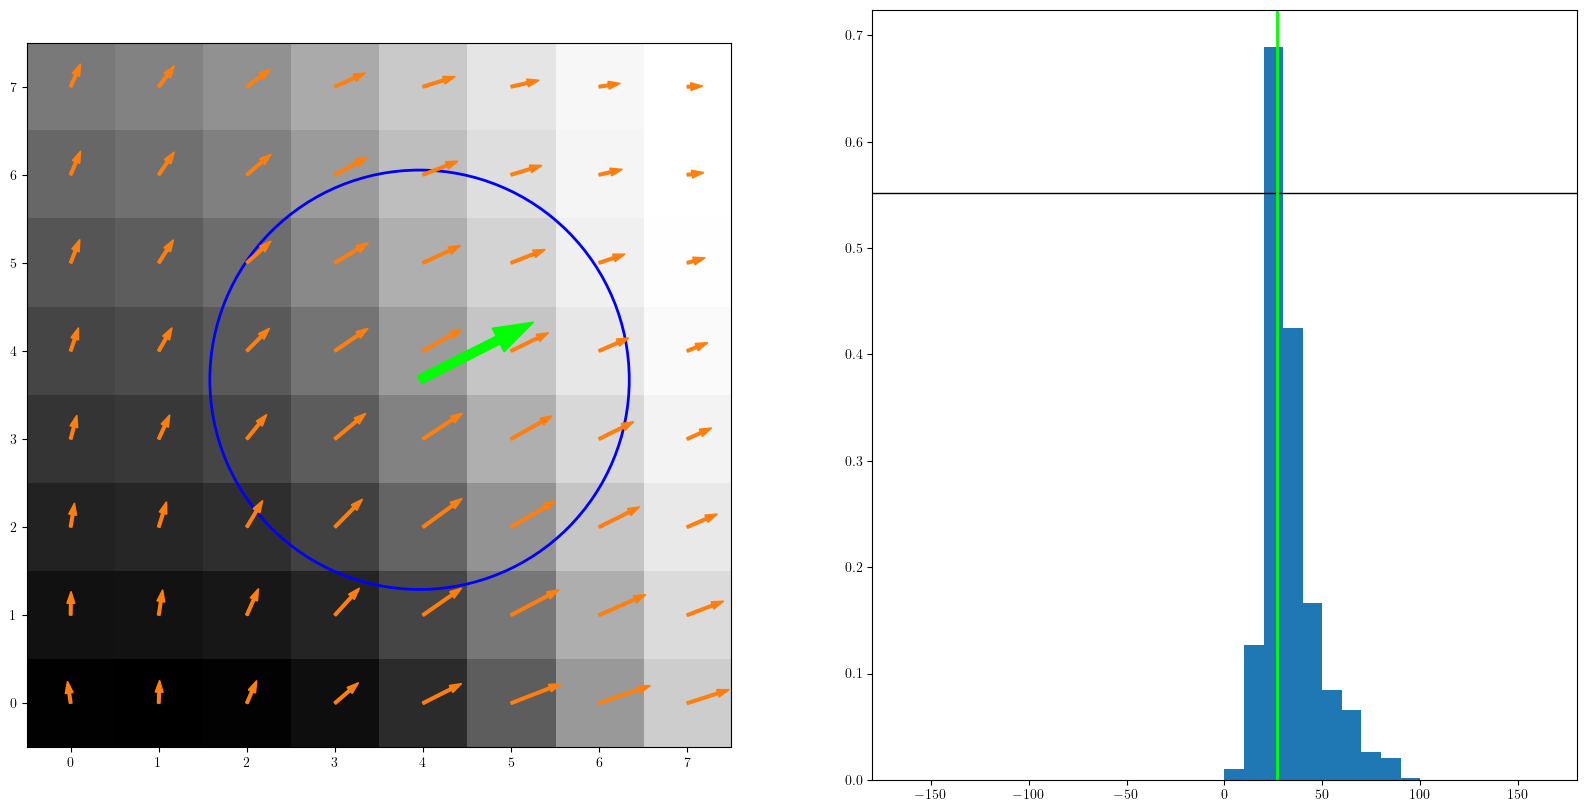

Angle Max:  55.0  Vertex:  59.1


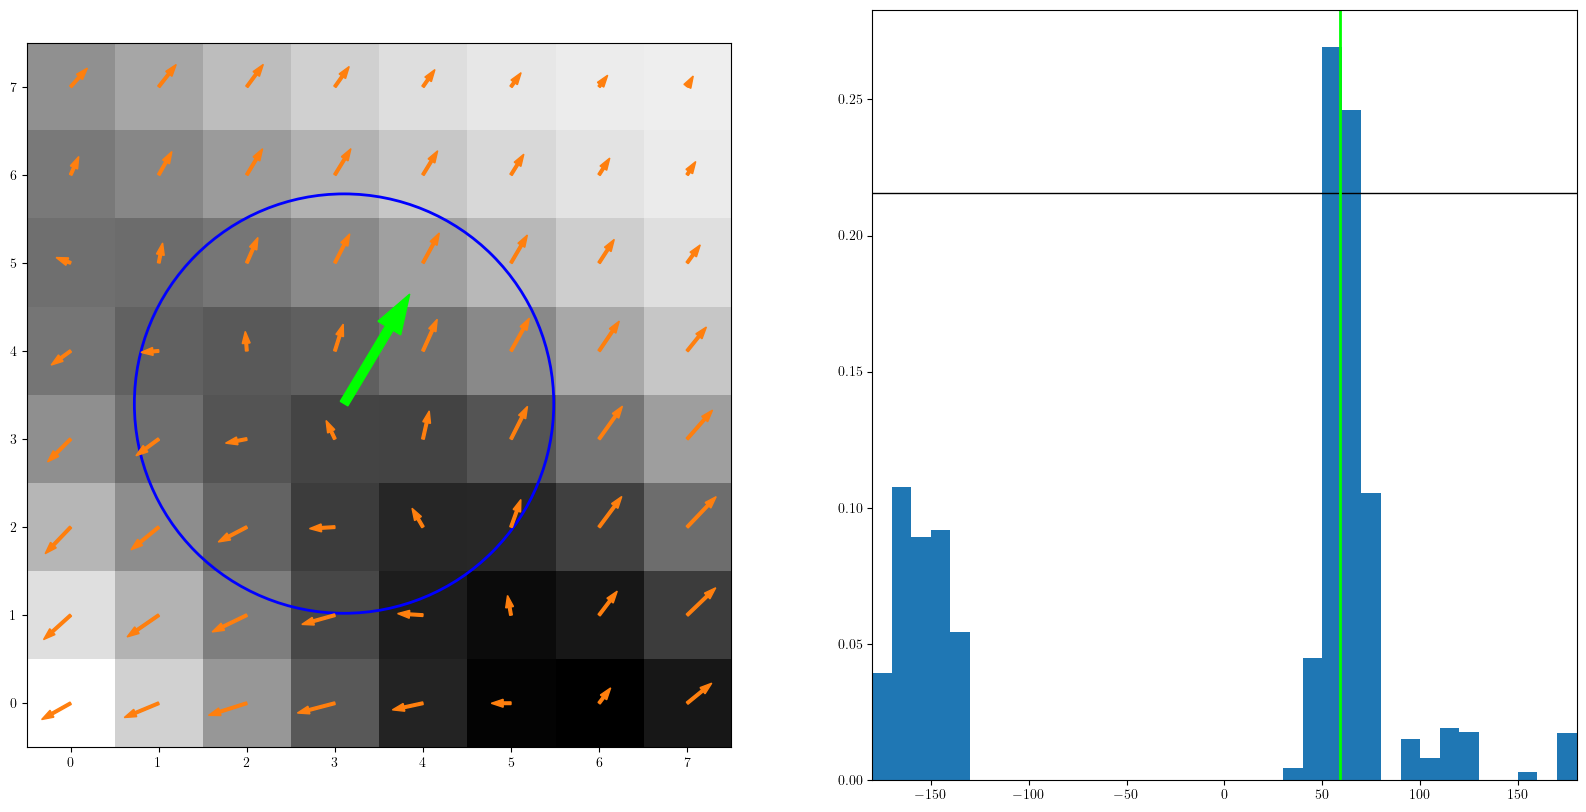

Angle Max:  65.0  Vertex:  62.8


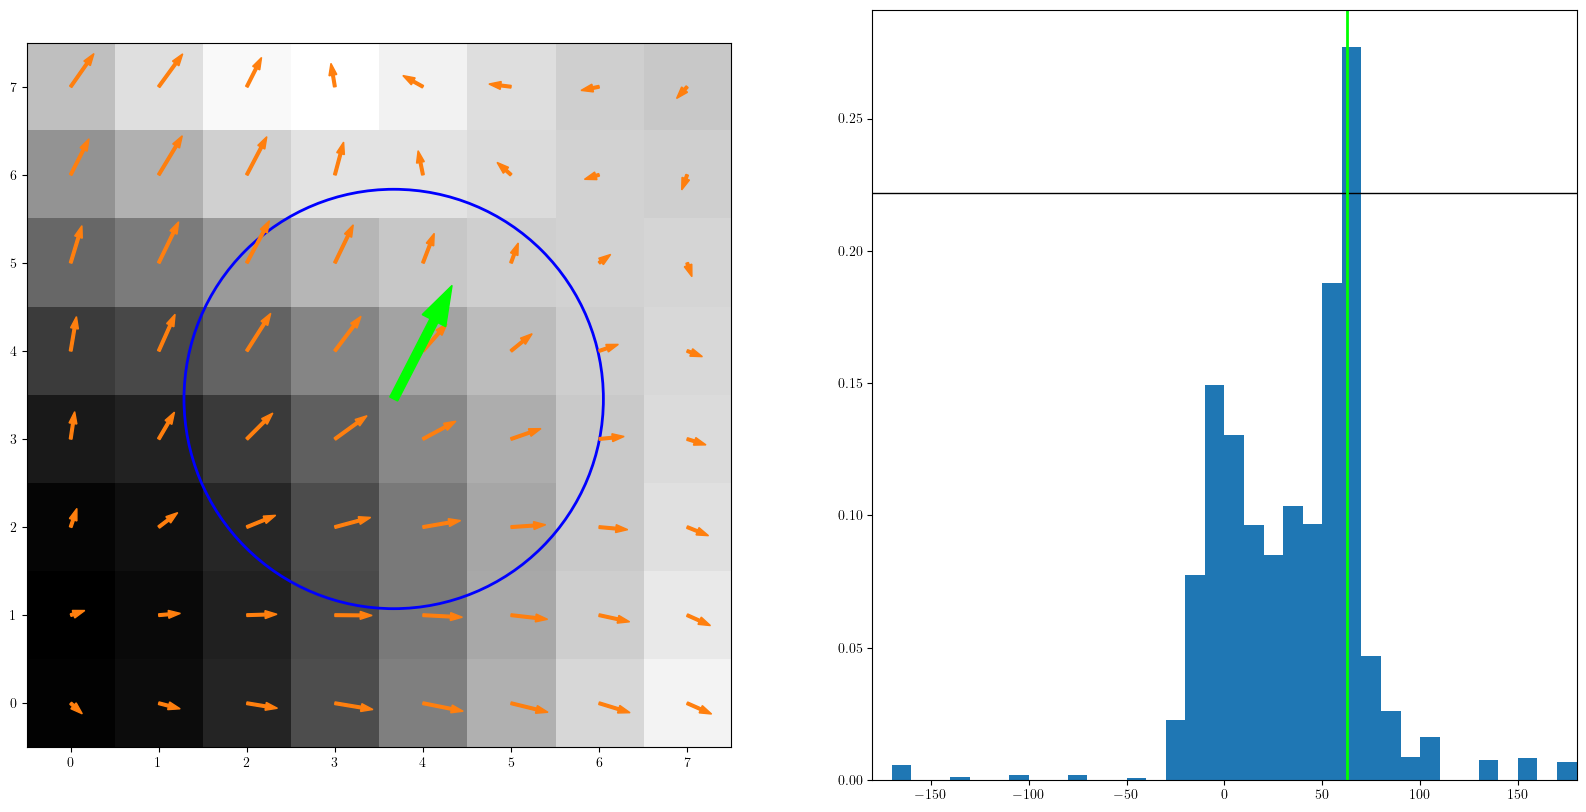

Angle Max:  95.0  Vertex:  92.9


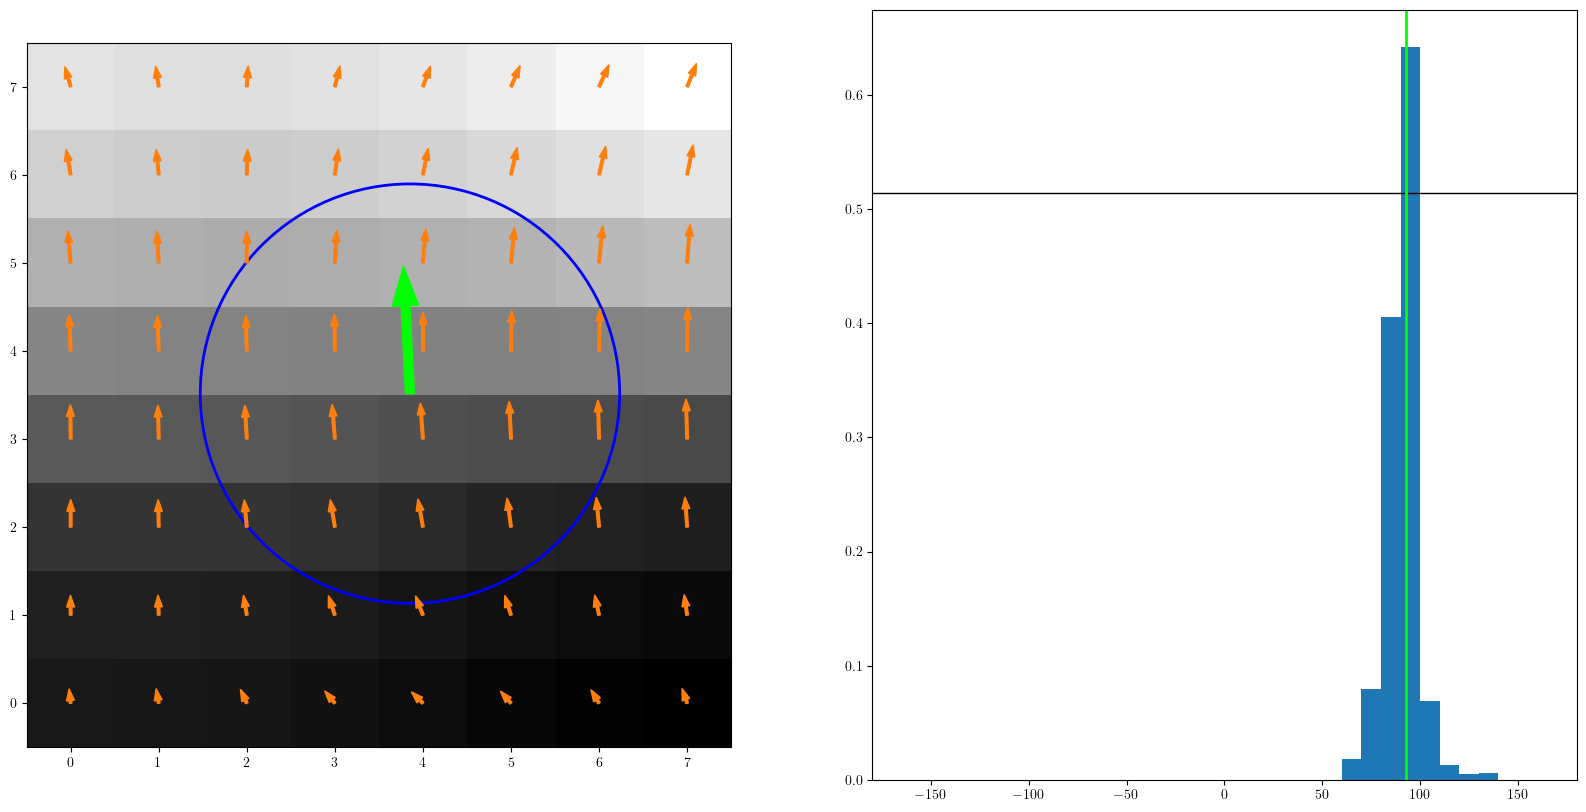

Original  Keypoints: 120
Localized Keypoints: 12
De-edged  Keypoints: 7
Oriented  Keypoints: 7


In [14]:
#%% Show keypoints local patches
wSigma     = 1.5*sigmas[level]             # 2004.Lowe, p. 100 - weight sigma
binEdges   = np.linspace(-180,180,37)      # 2004.Lowe, p.100
halfWidth  = int(np.ceil(sigmas[level]*2)) # Unclear from lowe

binCenters = (binEdges[1:] + binEdges[:-1])/2.0
    
nRows     = imageStack[level].shape[0]
nColumns  = imageStack[level].shape[1]

keypointsOriented = list()
for cpt,pt in enumerate(keypointsDeedged): 
    rkp = pt[1] # r = y
    ckp = pt[0] # c = x
    
    rMin = int(np.floor(rkp)-(halfWidth-1))
    rMax = rMin + 2*halfWidth - 1
    cMin = int(np.floor(ckp)-(halfWidth-1))
    cMax = cMin + 2*halfWidth - 1
    
    angles     = list()
    weights    = list()
    for r in range(rMin,rMax+1):
        for c in range(cMin,cMax+1):
            dx = imageD1h[r,c]
            dy = imageD1v[r,c] 
            gm = (dx**2 + dy**2)**(0.5)
            ga = np.arctan2(dy,dx)*(180/np.pi) # Convert to degrees
            wt = gm*np.exp(-0.5*((c-ckp)**2+(r-rkp)**2)/(wSigma**2))
            angles .append(ga)
            weights.append(wt)
    ret            = np.histogram(angles,bins=binEdges,weights=weights)
    binValues      = ret[0]
    angleThreshold = 0.8*max(binValues)
    iMaxima        = scipy.signal.argrelextrema(binValues, np.greater_equal,mode='wrap')[0]
    iMaxima        = iMaxima[binValues[iMaxima]>angleThreshold]
    #iMaxima        = np.argwhere(binValues>angleThreshold)[:,0]

    kpAngles = list()
    for iMax in iMaxima:
        if iMax>0 and iMax<len(binValues)-1:
            xv,yv = pcv.GetParabolaVertex(binCenters[iMax-1],binCenters[iMax],binCenters[iMax+1],binValues[iMax-1],binValues[iMax],binValues[iMax+1])
            print('Angle Max:%6.1f  Vertex:%6.1f' % (binCenters[iMax],xv))
            angleMax = xv
        else:
            angleMax = binCenters[iMax]
        
        kpAngles.append(angleMax)
        keypointsOriented.append((pt,angleMax))
    
    if cpt<10:
        figure = plt.figure(3)
        figure.set_size_inches(20,10)
        figure.clf()
        
        region = imageStack[level][rMin:(rMax+1),cMin:(cMax+1)]
        circle = plt.Circle((ckp-cMin,rkp-rMin),wSigma, color='b',fill=False,linewidth=2)
        axes = figure.add_subplot(1,2,1)    
        axes.imshow(region,cmap='gray')
        axes.add_patch(circle)
        for r in range(rMin,rMax+1):
            for c in range(cMin,cMax+1):
                dx = imageD1h[r,c]
                dy = imageD1v[r,c] 
                axes.arrow(c-cMin,r-rMin,5*dx,5*dy,color='tab:orange',width=0.03)         
        for angleMax in kpAngles:      
            axes.arrow(ckp-cMin,rkp-rMin,0.25*halfWidth*np.cos(angleMax*np.pi/180),0.25*halfWidth*np.sin(angleMax*np.pi/180),color='lime',width=0.1)                  
        axes.set_xlim([-0.5,halfWidth*2-0.5])            
        axes.set_ylim([-0.5,halfWidth*2-0.5])  
        
        axes = figure.add_subplot(1,2,2)
        axes.hist(angles,bins=binEdges,weights=weights)
        axes.axhline(angleThreshold,color='k',linewidth=1.0)
        for angleMax in kpAngles:      
            axes.axvline(angleMax,color='lime',linewidth=2.0)                  
        axes.set_xlim([binEdges[0],binEdges[-1]])
        plt.show()

print('Original  Keypoints: %d' % len(keypoints[level]))
print('Localized Keypoints: %d' % len(keypointsLocalized))
print('De-edged  Keypoints: %d' % len(keypointsDeedged))
print('Oriented  Keypoints: %d' % len(keypointsOriented))

### Image Descriptor

* Recall each keypoint has
    * Location $(x,y)$
    * Scale $\sigma$
    * Orientation $\theta$
* Provides a repeatable 2D coordinate system
    * Invariant to location, scale, and orientation
* Design goals
    * Discriptor for local image region (patch) that is
        * Highly distinctive
        * Invariant to other variations
            * 3D viewpoint (projective transforms)
            * Changes in illumination (e.g., Contrast and Brightness)
* Correlation measures
    * Highly sensitive to changes that cause mis-registration of samples
    * Affine or 3D viewpoint (projective) change
    * Non-rigid deformations
* Inspiration
    * Biological vision
    * Neurons respond to gradients at particular orientation and frequency
    * Not precisely localized
* Steps
    1. Select image gradient magnitudes and orientations near keypoint
        * Keypoint scale determines level of Gaussian blur (scale)
    1. Rotate coordinates relative to orientation of keypoint
        * Note that gradients are precomputed at all scales for efficiency
    1. Again, use a weighting locally
        * They chose a $\sigma$ equal to one half the width of the descriptor window
            * No rationale given
            * I misinterpreted this originally - not one half the width of the keypoint scale
        * Avoids sudden changes in the descriptor with small shifts
        * Less emphasis on gradients that are far away from the keypoint center
        * Weights by gradient magnitude as well, just like the orientation assignment 
            * This isn't very clear from the paper, but they assign a Gaussian weight "to the _magnitude_ of each sample point"
    1. Create an orientation histogram
        * Calculate separate histogram over each $4 \times 4$ region
        * Eight directions for each histogram
        * Use trilinear interpolation to ensure histogram doesn't change abruptly as points transition between bins
            * Trilinear is a linear weighting based on distance from the bin centers
            * This is a type of kernel density estimation with a tent kernel function
* Empirically they use 
    * a $16 \times 16$ region and divide it into $4 \times 4$ subregions for the local keypoint description
    * Eight bins for each
    * Total of $4 \times 4 \times 8 = 128$ element feature vector
* Normalized to unit length
    * Invariant to a change in contrast (scaling of pixel values)
    * Brightness changes (additions) already have no effect because based on gradients
    * Collectively invariant to affine transformations of intensity
        * Nonlinear effects such as saturation can, of course, affect it
* Clip large values at 0.2 
    * Motivation
        * Camera saturation due to illumination changes
        * Affect 3D surfaces with different orientations by different amounts
        * Can cause large change in magnitudes of some gradients and not others        
    * 3d surfaces can have large changes relative to the magnitude
    * Renormalize afterwards
    * Rationale
        * 0.2 based on experiments with images containing varying illuminations
    * Hackish
* Key Parameters (6.2)
    * Width $n$ of the $n \times n$ array of histograms
    * Number of orientations $r$ in each histogram
    * Descriptor thereby contains $r n^2$ elements
    * Tradeoff: as the size of the descriptor increases (larger patch/region)
        * Better discrimination in large database
        * More sensitive to shape distortions and occlusion
    * Optimization criterion
        * Correct nearest descriptor 
        * Again, looking essentially at stability when a transform is applied
        * Viewpoint transform with tilt by 50 degrees away from the viewer
        * Image noise
        * Correct match out of 40,000 keypoint candidates
    * Results
        * See Figure 8
    * Conclusions
        * A single orientation histogram has terrible performance
        * Using an array of histograms (2 $\times$ 2 or more) is important
        * Matters less how many bins are in the orientation histograms
        * Great performance is only about 50% accuracy 
            * Important to keep this in mind
            * The result is often wrong
        * Really well done optimization
        * Others have extended this to look at other types of histogram arrays
* Observations
    * Descriptor vector of 128 elements seems like a lot
    * Works well empircally
    * Others have used PCA to reduce the dimension of even larger descriptor vectors
* Sensitivity to Affine Change (6.3)
    * A rotation away from the viewer seems like a projective transform, but the paper describes it as affine
    * Performance, as shown in Figure 9, is rather remarkable
    

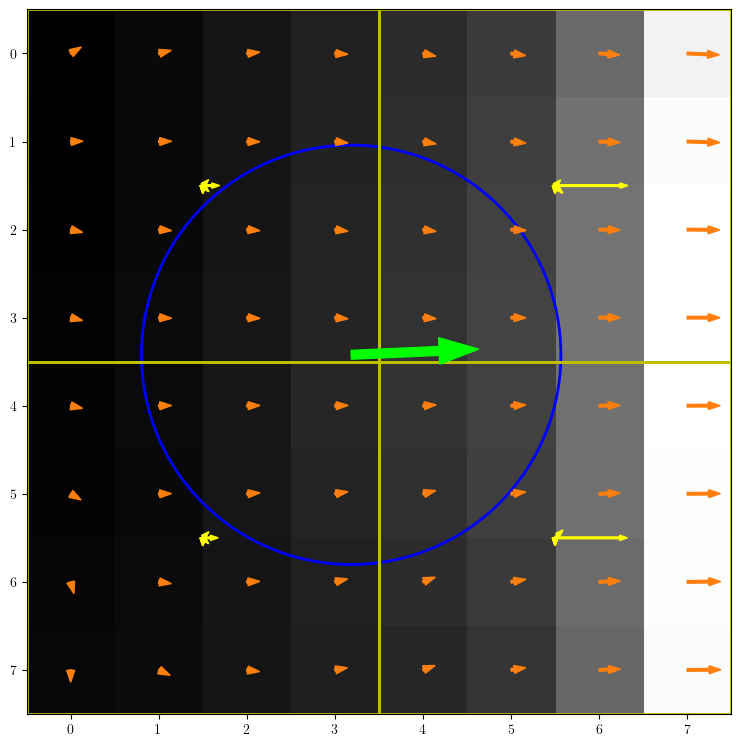

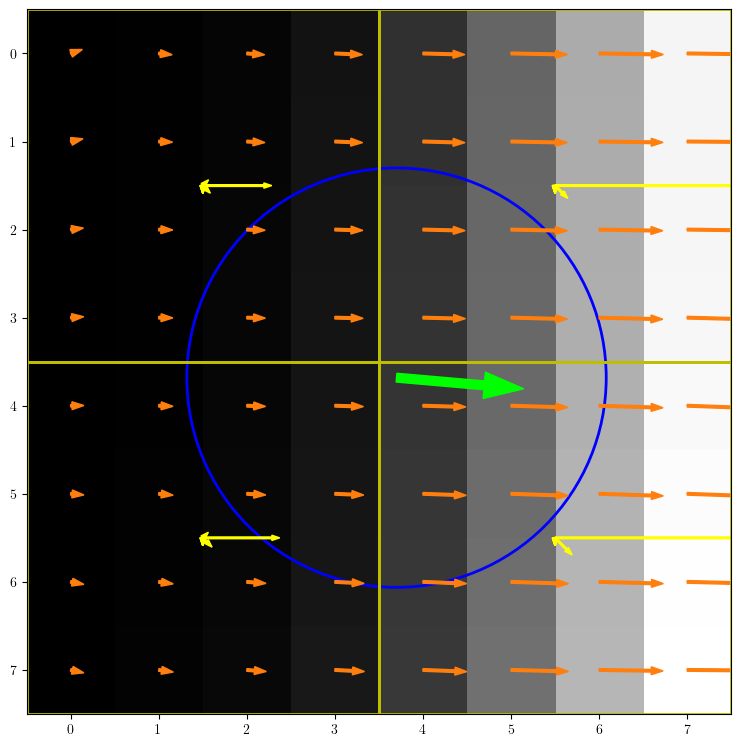

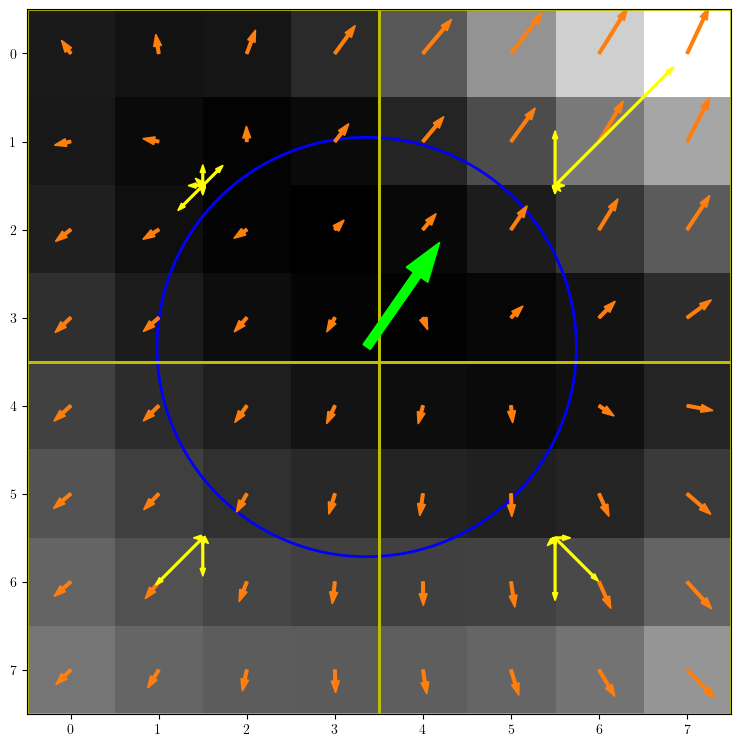

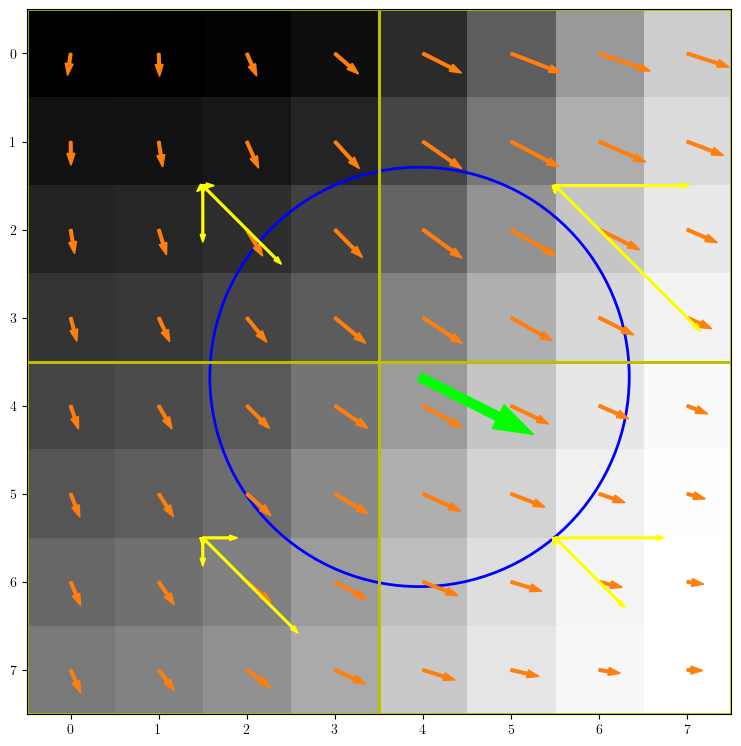

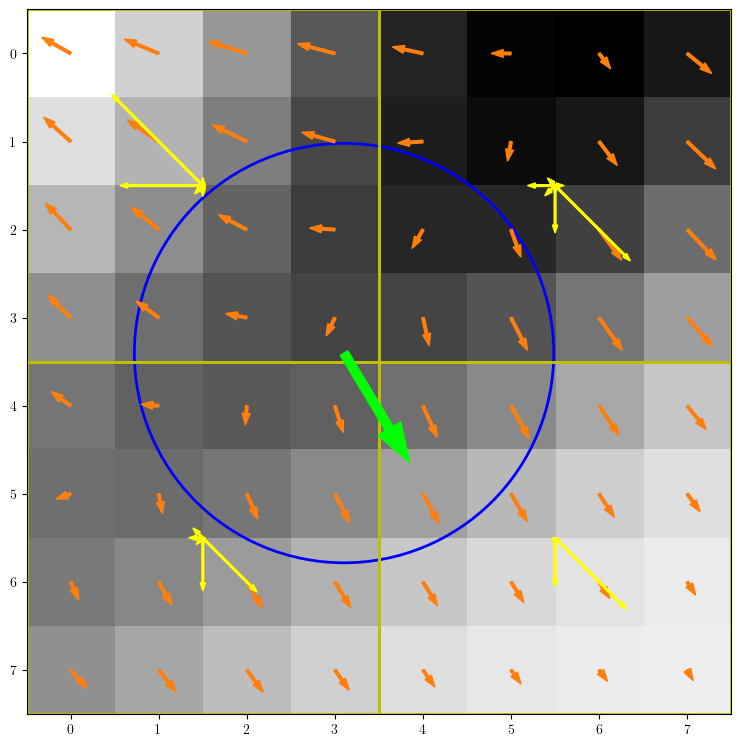

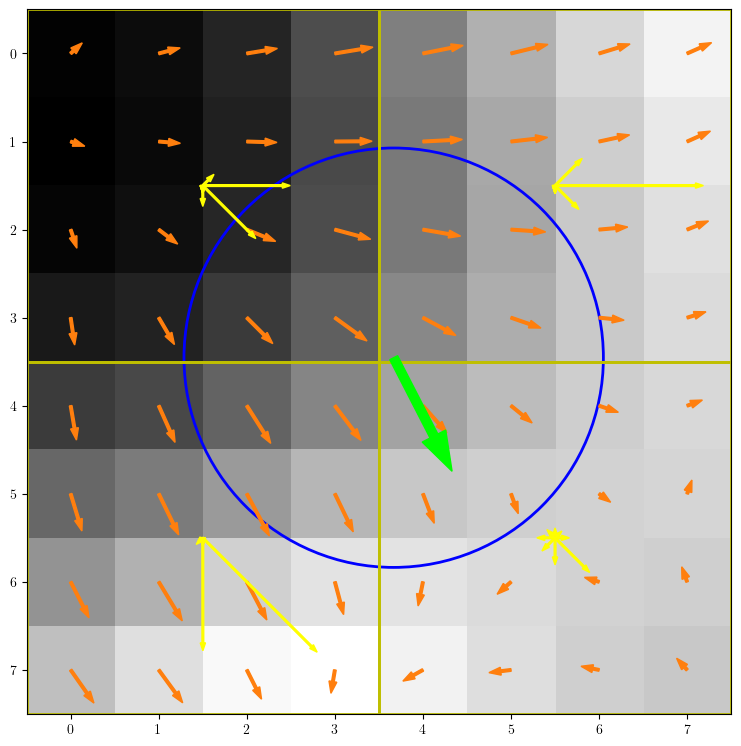

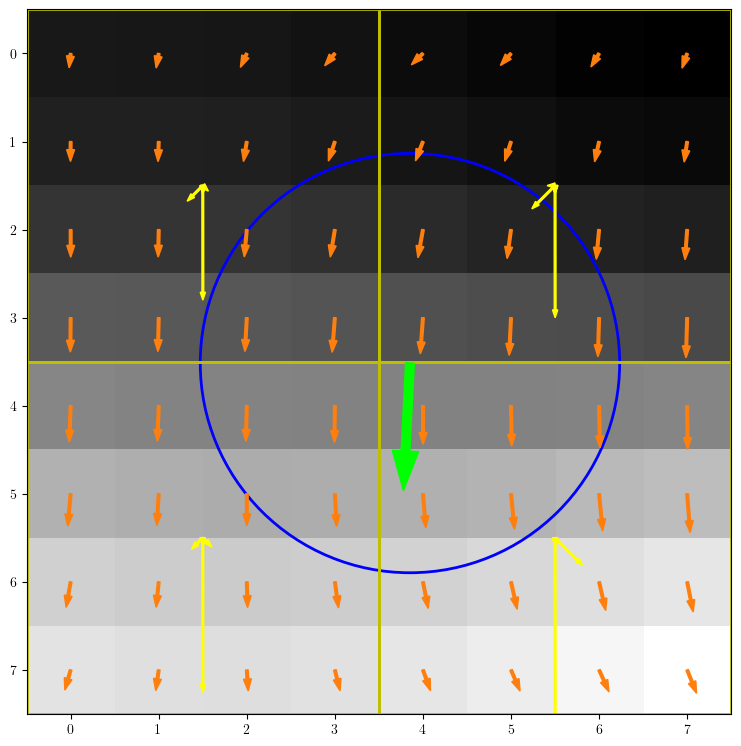

In [15]:
#%% Keypoint Descriptor

nDescriptorArraysPerSide = 2 # Try changing this to 4
nSamplesPerSide          = 4
nOrientationBins         = 8 

nWindowWidth = nDescriptorArraysPerSide*nSamplesPerSide
dSigma       = 0.5*nWindowWidth                        # 2004.Lowe, p. 101 
halfWidth    = nWindowWidth/2

binWidth = 360/nOrientationBins
binCenters = np.linspace(-180,180,nOrientationBins+1)
binValues  = np.zeros(nOrientationBins)
    
nRows     = imageStack[level].shape[0]
nColumns  = imageStack[level].shape[1]

for cpt,kp in enumerate(keypointsOriented): 
    rkp = kp[0][1] # r = y
    ckp = kp[0][0] # c = x
    akp = kp[1]
    
    rMin = int(np.floor(rkp)-(halfWidth-1))
    rMax = rMin + nWindowWidth - 1
    cMin = int(np.floor(ckp)-(halfWidth-1))
    cMax = cMin + nWindowWidth - 1
    if rMin<0 or rMax>nRows-1 or cMin<0 or cMax>nColumns-1:
        print('Skipping')
        continue # Skip keypoints that are near the edges. Can't form full descriptors
        
    if cpt<10:
        figure = plt.figure(3)
        figure.set_size_inches(20,10)
        figure.clf()
        
        region = imageStack[level][rMin:(rMax+1),cMin:(cMax+1)]
        circle = plt.Circle((ckp-cMin,rkp-rMin),wSigma, color='b',fill=False,linewidth=2)
        axes = figure.add_subplot(1,2,1)   
        axes.imshow(region,cmap='gray')
        axes.add_patch(circle)
        for r in range(rMin,rMax+1):
            for c in range(cMin,cMax+1):
                dx = imageD1h[r,c]
                dy = imageD1v[r,c] 
                axes.arrow(c-cMin,r-rMin,5*dx,5*dy,color='tab:orange',width=0.03)    
        
        descriptorVector = np.array([])
        for rArray in range(nDescriptorArraysPerSide):
            for cArray in range(nDescriptorArraysPerSide):
                rArrayMin = rArray*nSamplesPerSide + rMin
                rArrayMax = rArrayMin + nSamplesPerSide - 1
                cArrayMin = cArray*nSamplesPerSide + cMin
                cArrayMax = cArrayMin + nSamplesPerSide - 1
                
                angles     = list()
                weights    = list()
                for r in range(rArrayMin,rArrayMax+1):
                    for c in range(cArrayMin,cArrayMax+1):
                        dx = imageD1h[r,c]
                        dy = imageD1v[r,c] 
                        gm = (dx**2 + dy**2)**(0.5)
                        ga = np.arctan2(dy,dx)*(180/np.pi) # Convert to degrees
                        wt = gm*np.exp(-0.5*((c-ckp)**2+(r-rkp)**2)/(dSigma**2))
                        angles.append(ga)
                        weights.append(wt)
                        
                # Bilinear Interpolation of Histogram
                binValues = np.zeros_like(binCenters)
                for iBin,binCenter in enumerate(binCenters):
                    for cAngle,angle in enumerate(angles):
                        nad              = (angle-binCenter)/binWidth # Normalized angle difference
                        bwt              = (1-np.abs(nad))*(np.abs(nad)<1)     # Tent function for bilinear interpolation   
                        binValues[iBin] += bwt*weights[cAngle]
                binValues[0] += binValues[-1] # First and last bin are the same, +/- 180 degrees, so combine them into the first bin             
                for ib in range(nOrientationBins):
                    rCenter   = (rArrayMin+rArrayMax)/2.0
                    cCenter   = (cArrayMin+cArrayMax)/2.0
                    angle     = binCenters[ib]
                    magnitude = binValues [ib]
                    dx = nSamplesPerSide*magnitude*np.cos(angle*np.pi/180.09)
                    dy = nSamplesPerSide*magnitude*np.sin(angle*np.pi/180.0)
                    axes.arrow(cCenter-cMin,rCenter-rMin,dx,dy,color='yellow',width=0.02)    
                descriptorVector = np.concatenate((descriptorVector,binValues[:-1]))
                rectangle = plt.Rectangle((cArrayMin-cMin-0.5,rArrayMin-rMin-0.5),nSamplesPerSide,nSamplesPerSide, color='y',fill=False,linewidth=2)
                axes.add_patch(rectangle)
                axes.set_xlim([-0.5,nWindowWidth+0.5])            
                axes.set_ylim([-0.5,nWindowWidth+0.5]) 
        axes.arrow(ckp-cMin,rkp-rMin,0.25*halfWidth*np.cos(akp*np.pi/180),0.25*halfWidth*np.sin(akp*np.pi/180),color='lime',width=0.1)                   
        axes.set_xlim([-0.5,nWindowWidth-0.5])
        axes.set_ylim([-0.5,nWindowWidth-0.5])
        axes.invert_yaxis()        
                
        plt.show()

## Matching (6.4)
* Matching in a large database can require a lot of computation
* In the paper the descriptors are 128 elements in size, and the data base contains 40,000 keypoints (candidate neighbors)
* This is from a relatively small sample of just 32 images
* In larger set of 112 images with random scale, rotation, 2% image noise, and depth rotation of 30 degrees, accuracy is shown in Figure 10
* Main problem is finding keypoints after transform
    * Once the keypoint is found, the matching occurs with high probability

### Keypoint Matching Revised (7.1)
* Nearest neighbor may still be with a distractor
* Might not be very good
* Later in the paper (Section 7.1) he suggests comparing two distances
    * Nearest neighbor
    * Second nearest neighbor
* During a true match, the nearest neighbor should be much closer
* Key idea is that false matches will have other false matches that are nearly the same distance
* Figure 11 shows the PDFs of correct and incorrect matches versus the ratio of these distances
    * Sweet spot is around 0.75
    * They chose 0.8
* Great justification for the design decision based on an optimization and quantifying the tradeoffs in convincing data

### Nearest Neighbor Algorithms
* There are fast algorithms for finding the nearest neighbor
* I've published such an algorithm
* Also approximate algorithms exist, like Lowe used
* Orders of magnitude improvement are possible with modest losss in performance (percent of correct matches)


## Tracking
* Covered in brifly in the book (4.1.4, Pg. 207), but not Lowe
* Mostly used in video tracking applications
* Usually _detect then track_ approach
* Often tracking translation alone with sum of squared differences is enough
* Note tracking often needs to be done in real time, so computational contraints are often larger
    * May have power/battery budget to consider, as well as time budget
* Often a hierarchical search strategy
* Lower resolutions first for the initial search, and then refine
* May be able to perform just local searches if camera doesn't move too much
* Motion blur can be an issue
* If only track from one frame to another, could have an accumulated error similar to random walk


# Closing Remarks
* Important paper with many key ideas
* There have been many extensions of this work
* If you understand SIFT, you can probably understand these other methods
* Important part of SIFT is the key ideas and insights, which are incorporated into subsequent improvements